# OOF stacking
> 7강 oof stacking을 베이스라인에 구현해보는 퀴즈의 정답 코드입니다! 아래 베이스라인은 그대로 실행시켜주시고 `oof stacking` 파트에서 시작해주시면 됩니다! 베이스라인의 `run`함수는 사용되지 않는다는 점에 주의해주세요!

## 베이스라인
> 처음에 주어지는 노트북 베이스라인 코드입니다!

In [ ]:
!pip install easydict

In [ ]:
import pandas as pd
import os
import torch
import easydict
import numpy as np
from sklearn.preprocessing import LabelEncoder
import time
import datetime
from datetime import datetime
import random
import wandb

### 1. 데이터 로드 및 전처리 컴포넌트

In [ ]:
import os
from datetime import datetime
import time
import tqdm
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch

class Preprocess:
    def __init__(self,args):
        self.args = args
        self.train_data = None
        self.test_data = None
        

    def get_train_data(self):
        return self.train_data

    def get_test_data(self):
        return self.test_data

    def split_data(self, data, ratio=0.7, shuffle=True, seed=0):
        """
        split data into two parts with a given ratio.
        """
        if shuffle:
            random.seed(seed) # fix to default seed 0
            random.shuffle(data)

        size = int(len(data) * ratio)
        data_1 = data[:size]
        data_2 = data[size:]

        return data_1, data_2

    def __save_labels(self, encoder, name):
        le_path = os.path.join(self.args.asset_dir, name + '_classes.npy')
        np.save(le_path, encoder.classes_)

    def __preprocessing(self, df, is_train = True):
        cate_cols = ['assessmentItemID', 'testId', 'KnowledgeTag']

        if not os.path.exists(self.args.asset_dir):
            os.makedirs(self.args.asset_dir)
            
        for col in cate_cols:
            
            
            le = LabelEncoder()
            if is_train:
                #For UNKNOWN class
                a = df[col].unique().tolist() + ['unknown']
                le.fit(a)
                self.__save_labels(le, col)
            else:
                label_path = os.path.join(self.args.asset_dir,col+'_classes.npy')
                le.classes_ = np.load(label_path)
                
                df[col] = df[col].apply(lambda x: x if x in le.classes_ else 'unknown')

            #모든 컬럼이 범주형이라고 가정
            df[col]= df[col].astype(str)
            test = le.transform(df[col])
            df[col] = test
            

        def convert_time(s):
            timestamp = time.mktime(datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())
            return int(timestamp)

        df['Timestamp'] = df['Timestamp'].apply(convert_time)
        
        return df

    def __feature_engineering(self, df):
        #TODO
        return df

    def load_data_from_file(self, file_name, is_train=True):
        csv_file_path = os.path.join(self.args.data_dir, file_name)
        df = pd.read_csv(csv_file_path)#, nrows=100000)
        df = self.__feature_engineering(df)
        df = self.__preprocessing(df, is_train)

        # 추후 feature를 embedding할 시에 embedding_layer의 input 크기를 결정할때 사용

                
        self.args.n_questions = len(np.load(os.path.join(self.args.asset_dir,'assessmentItemID_classes.npy')))
        self.args.n_test = len(np.load(os.path.join(self.args.asset_dir,'testId_classes.npy')))
        self.args.n_tag = len(np.load(os.path.join(self.args.asset_dir,'KnowledgeTag_classes.npy')))
        


        df = df.sort_values(by=['userID','Timestamp'], axis=0)
        columns = ['userID', 'assessmentItemID', 'testId', 'answerCode', 'KnowledgeTag']
        group = df[columns].groupby('userID').apply(
                lambda r: (
                    r['testId'].values, 
                    r['assessmentItemID'].values,
                    r['KnowledgeTag'].values,
                    r['answerCode'].values
                )
            )

        return group.values

    def load_train_data(self, file_name):
        self.train_data = self.load_data_from_file(file_name)

    def load_test_data(self, file_name):
        self.test_data = self.load_data_from_file(file_name, is_train=False)




### 2. 데이터 셋 / 데이터 로더

In [ ]:
class DKTDataset(torch.utils.data.Dataset):
    def __init__(self, data, args):
        self.data = data
        self.args = args

    def __getitem__(self, index):
        row = self.data[index]

        # 각 data의 sequence length
        seq_len = len(row[0])

        test, question, tag, correct = row[0], row[1], row[2], row[3]
        

        cate_cols = [test, question, tag, correct]

        # max seq len을 고려하여서 이보다 길면 자르고 아닐 경우 그대로 냅둔다
        if seq_len > self.args.max_seq_len:
            for i, col in enumerate(cate_cols):
                cate_cols[i] = col[-self.args.max_seq_len:]
            mask = np.ones(self.args.max_seq_len, dtype=np.int16)
        else:
            mask = np.zeros(self.args.max_seq_len, dtype=np.int16)
            mask[-seq_len:] = 1

        # mask도 columns 목록에 포함시킴
        cate_cols.append(mask)

        # np.array -> torch.tensor 형변환
        for i, col in enumerate(cate_cols):
            cate_cols[i] = torch.tensor(col)

        return cate_cols

    def __len__(self):
        return len(self.data)




def collate(batch):
    col_n = len(batch[0])
    col_list = [[] for _ in range(col_n)]
    max_seq_len = len(batch[0][-1])

        
    # batch의 값들을 각 column끼리 그룹화
    for row in batch:
        for i, col in enumerate(row):
            pre_padded = torch.zeros(max_seq_len)
            pre_padded[-len(col):] = col
            col_list[i].append(pre_padded)


    for i, _ in enumerate(col_list):
        col_list[i] =torch.stack(col_list[i])
    
    return tuple(col_list)


def get_loaders(args, train, valid):

    pin_memory = False
    train_loader, valid_loader = None, None
    
    if train is not None:
        trainset = DKTDataset(train, args)
        train_loader = torch.utils.data.DataLoader(trainset, num_workers=args.num_workers, shuffle=True,
                            batch_size=args.batch_size, pin_memory=pin_memory, collate_fn=collate)
    if valid is not None:
        valset = DKTDataset(valid, args)
        valid_loader = torch.utils.data.DataLoader(valset, num_workers=args.num_workers, shuffle=False,
                            batch_size=args.batch_size, pin_memory=pin_memory, collate_fn=collate)

    return train_loader, valid_loader

### 3. LSTM 기반의 모델

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import copy
import math

try:
    from transformers.modeling_bert import BertConfig, BertEncoder, BertModel    
except:
    from transformers.models.bert.modeling_bert import BertConfig, BertEncoder, BertModel    




class LSTM(nn.Module):

    def __init__(self, args):
        super(LSTM, self).__init__()
        self.args = args
        self.device = args.device

        self.hidden_dim = self.args.hidden_dim
        self.n_layers = self.args.n_layers

        # Embedding 
        # interaction은 현재 correct로 구성되어있다. correct(1, 2) + padding(0)
        self.embedding_interaction = nn.Embedding(3, self.hidden_dim//3)
        self.embedding_test = nn.Embedding(self.args.n_test + 1, self.hidden_dim//3)
        self.embedding_question = nn.Embedding(self.args.n_questions + 1, self.hidden_dim//3)
        self.embedding_tag = nn.Embedding(self.args.n_tag + 1, self.hidden_dim//3)

        # embedding combination projection
        self.comb_proj = nn.Linear((self.hidden_dim//3)*4, self.hidden_dim)

        self.lstm = nn.LSTM(self.hidden_dim,
                            self.hidden_dim,
                            self.n_layers,
                            batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(self.hidden_dim, 1)

        self.activation = nn.Sigmoid()

    def init_hidden(self, batch_size):
        h = torch.zeros(
            self.n_layers,
            batch_size,
            self.hidden_dim)
        h = h.to(self.device)

        c = torch.zeros(
            self.n_layers,
            batch_size,
            self.hidden_dim)
        c = c.to(self.device)

        return (h, c)

    def forward(self, input):

        test, question, tag, _, mask, interaction, _ = input

        batch_size = interaction.size(0)

        # Embedding

        embed_interaction = self.embedding_interaction(interaction)
        embed_test = self.embedding_test(test)
        embed_question = self.embedding_question(question)
        embed_tag = self.embedding_tag(tag)
        

        embed = torch.cat([embed_interaction,
                           embed_test,
                           embed_question,
                           embed_tag,], 2)

        X = self.comb_proj(embed)

        hidden = self.init_hidden(batch_size)
        out, hidden = self.lstm(X, hidden)
        out = out.contiguous().view(batch_size, -1, self.hidden_dim)

        out = self.fc(out)
        preds = self.activation(out).view(batch_size, -1)

        return preds



### 4. 모델 훈련을 위한 함수들

In [ ]:
import os, sys

import numpy as np

import tarfile
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW

from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import get_linear_schedule_with_warmup
from transformers import get_cosine_schedule_with_warmup

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import scipy.stats


# 훈련을 하기 위한 세팅
def get_optimizer(model, args):
    if args.optimizer == 'adam':
        optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=0.01)
    if args.optimizer == 'adamW':
        optimizer = AdamW(model.parameters(), lr=args.lr, weight_decay=0.01)
    
    # 모든 parameter들의 grad값을 0으로 초기화
    optimizer.zero_grad()
    
    return optimizer

def get_scheduler(optimizer, args):
    if args.scheduler == 'plateau':
        scheduler = ReduceLROnPlateau(optimizer, patience=10, factor=0.5, mode='max', verbose=True)
    elif args.scheduler == 'linear_warmup':
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=args.warmup_steps,
                                                    num_training_steps=args.total_steps)
    return scheduler

def get_criterion(pred, target):
    loss = nn.BCELoss(reduction="none")
    return loss(pred, target)

def get_metric(targets, preds):
    auc = roc_auc_score(targets, preds)
    acc = accuracy_score(targets, np.where(preds >= 0.5, 1, 0))

    return auc, acc

def get_model(args):
    """
    Load model and move tensors to a given devices.
    """
    if args.model == 'lstm': model = LSTM(args)
    

    model.to(args.device)

    return model


# 배치 전처리
def process_batch(batch, args):

    test, question, tag, correct, mask = batch
    
    
    # change to float
    mask = mask.type(torch.FloatTensor)
    correct = correct.type(torch.FloatTensor)

    #  interaction을 임시적으로 correct를 한칸 우측으로 이동한 것으로 사용
    #    saint의 경우 decoder에 들어가는 input이다
    interaction = correct + 1 # 패딩을 위해 correct값에 1을 더해준다.
    interaction = interaction.roll(shifts=1, dims=1)
    interaction[:, 0] = 0 # set padding index to the first sequence
    interaction = (interaction * mask).to(torch.int64)
    # print(interaction)
    # exit()
    #  test_id, question_id, tag
    test = ((test + 1) * mask).to(torch.int64)
    question = ((question + 1) * mask).to(torch.int64)
    tag = ((tag + 1) * mask).to(torch.int64)

    # gather index
    # 마지막 sequence만 사용하기 위한 index
    gather_index = torch.tensor(np.count_nonzero(mask, axis=1))
    gather_index = gather_index.view(-1, 1) - 1


    # device memory로 이동

    test = test.to(args.device)
    question = question.to(args.device)


    tag = tag.to(args.device)
    correct = correct.to(args.device)
    mask = mask.to(args.device)

    interaction = interaction.to(args.device)
    gather_index = gather_index.to(args.device)

    return (test, question,
            tag, correct, mask,
            interaction, gather_index)


# loss계산하고 parameter update!
def compute_loss(preds, targets):
    """
    Args :
        preds   : (batch_size, max_seq_len)
        targets : (batch_size, max_seq_len)

    """
    loss = get_criterion(preds, targets)
    #마지막 시퀀드에 대한 값만 loss 계산
    loss = loss[:,-1]
    loss = torch.mean(loss)
    return loss

def update_params(loss, model, optimizer, args):
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_grad)
    optimizer.step()
    optimizer.zero_grad()



def save_checkpoint(state, model_dir, model_filename):
    print('saving model ...')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)    
    torch.save(state, os.path.join(model_dir, model_filename))



def load_model(args):
    
    
    model_path = os.path.join(args.model_dir, args.model_name)
    print("Loading Model from:", model_path)
    load_state = torch.load(model_path)
    model = get_model(args)

    # 1. load model state
    model.load_state_dict(load_state['state_dict'], strict=True)
   
    
    print("Loading Model from:", model_path, "...Finished.")
    return model



### 5. 전체 프로세스를 담당하는 함수들

In [ ]:
def train(train_loader, model, optimizer, args):
    model.train()

    total_preds = []
    total_targets = []
    losses = []
    for step, batch in enumerate(train_loader):
        input = process_batch(batch, args)
        preds = model(input)
        targets = input[3] # correct


        loss = compute_loss(preds, targets)
        update_params(loss, model, optimizer, args)

        if step % args.log_steps == 0:
            print(f"Training steps: {step} Loss: {str(loss.item())}")
        
        # predictions
        preds = preds[:,-1]
        targets = targets[:,-1]

        if args.device == 'cuda':
            preds = preds.to('cpu').detach().numpy()
            targets = targets.to('cpu').detach().numpy()
        else: # cpu
            preds = preds.detach().numpy()
            targets = targets.detach().numpy()
        
        total_preds.append(preds)
        total_targets.append(targets)
        losses.append(loss)
      

    total_preds = np.concatenate(total_preds)
    total_targets = np.concatenate(total_targets)

    # Train AUC / ACC
    auc, acc = get_metric(total_targets, total_preds)
    loss_avg = sum(losses)/len(losses)
    print(f'TRAIN AUC : {auc} ACC : {acc}')
    return auc, acc, loss_avg
    

def validate(valid_loader, model, args):
    model.eval()

    total_preds = []
    total_targets = []
    for step, batch in enumerate(valid_loader):
        input = process_batch(batch, args)

        preds = model(input)
        targets = input[3] # correct


        # predictions
        preds = preds[:,-1]
        targets = targets[:,-1]
    
        if args.device == 'cuda':
            preds = preds.to('cpu').detach().numpy()
            targets = targets.to('cpu').detach().numpy()
        else: # cpu
            preds = preds.detach().numpy()
            targets = targets.detach().numpy()

        total_preds.append(preds)
        total_targets.append(targets)

    total_preds = np.concatenate(total_preds)
    total_targets = np.concatenate(total_targets)

    # Train AUC / ACC
    auc, acc = get_metric(total_targets, total_preds)
    
    print(f'VALID AUC : {auc} ACC : {acc}\n')

    return auc, acc, total_preds, total_targets



def inference(args, test_data):
    
    model = load_model(args)
    model.eval()
    _, test_loader = get_loaders(args, None, test_data)
    
    
    total_preds = []
    
    for step, batch in enumerate(test_loader):
        input = process_batch(batch, args)

        preds = model(input)
        

        # predictions
        preds = preds[:,-1]
        

        if args.device == 'cuda':
            preds = preds.to('cpu').detach().numpy()
        else: # cpu
            preds = preds.detach().numpy()
            
        total_preds += list(preds)

    write_path = os.path.join(args.output_dir, "output.csv")
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)    
    with open(write_path, 'w', encoding='utf8') as w:
        print("writing prediction : {}".format(write_path))
        w.write("id,prediction\n")
        for id, p in enumerate(total_preds):
            w.write('{},{}\n'.format(id,p))




In [ ]:
data_dir = '/opt/ml/input/data/train_dataset'
file_name = 'train_data.csv'
test_file_name = 'test_data.csv'

config = {}

# 설정
config['seed'] = 42
config['device'] = "cuda" if torch.cuda.is_available() else "cpu"
config['data_dir'] = data_dir
config['asset_dir'] = 'asset'
config['model_dir'] = 'models'
config['model_name'] = 'model.pt'
config['output_dir'] = 'output'

# 데이터
config['max_seq_len'] = 20
config['num_workers'] = 1


# 모델
config['hidden_dim'] = 64
config['n_layers'] = 2
config['dropout'] = 0.2

# 훈련
config['n_epochs'] = 20
config['batch_size'] = 64
config['lr'] = 0.0001
config['clip_grad'] = 10
config['log_steps'] = 50
config['patience'] = 5



### 중요 ###
config['model'] = 'lstm'
config['optimizer'] = 'adam'
config['scheduler'] = 'plateau'


args = easydict.EasyDict(config)

## `OOF Stacking`

> 여러번의 실험을 거쳐 가장 좋은 실험 세팅을 찾은 후에 이 세팅값인 args들을 바탕으로 모델 훈련부터 oof 생성, meta 모델 훈련까지 한번에 해결하는 목적의 `Stacking` 클래스와 `Trainer` 클래스를 사용하여 oof stacking을 진행할 것이다!


### 코드

- Trainer
- Stacking

#### 💯 Trainer
- 모델 훈련 및 훈련된 모델 return (베이스라인 `run`함수 기능)
- 데이터 예측값인 predict 가져오기
- 데이터 라벨인 y값 가져오기

In [ ]:
from tqdm import tqdm

class Trainer:
    def __init__(self):
        pass

    def train(self, args, train_data, valid_data):
        """훈련을 마친 모델을 반환한다"""

        # args update
        self.args = args

        train_loader, valid_loader = get_loaders(args, train_data, valid_data)
        
        # only when using warmup scheduler
        args.total_steps = int(len(train_loader.dataset) / args.batch_size) * (args.n_epochs)
        args.warmup_steps = args.total_steps // 10
            
        model = get_model(args)
        optimizer = get_optimizer(model, args)
        scheduler = get_scheduler(optimizer, args)

        best_auc = -1
        best_model = -1
        early_stopping_counter = 0
        for epoch in tqdm(range(args.n_epochs)):

            ### TRAIN
            train_auc, train_acc, loss_avg = train(train_loader, model, optimizer, args)
            
            ### VALID
            auc, acc, preds, targets = validate(valid_loader, model, args)

            ### model save or early stopping
            if auc > best_auc:
                best_auc = auc
                best_model = copy.deepcopy(model)
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= args.patience:
                    print(f'EarlyStopping counter: {early_stopping_counter} out of {args.patience}')
                    break

            # scheduler
            if args.scheduler == 'plateau':
                scheduler.step(best_auc)
            else:
                scheduler.step()

        return best_model

    def evaluate(self, args, model, valid_data):
        """훈련된 모델과 validation 데이터셋을 제공하면 predict 반환"""
        pin_memory = False

        valset = DKTDataset(valid_data, args)
        valid_loader = torch.utils.data.DataLoader(valset, shuffle=False,
                                                   batch_size=args.batch_size,
                                                   pin_memory=pin_memory,
                                                   collate_fn=collate)

        auc, acc, preds, _ = validate(valid_loader, model, args)
        print(f"AUC : {auc}, ACC : {acc}")

        return preds

    def test(self, args, model, test_data):
        model.eval()
        _, test_loader = get_loaders(args, None, test_data)

        total_preds = []
        for step, batch in enumerate(test_loader):
            input = process_batch(batch, args)

            preds = model(input)

            # predictions
            preds = preds[:,-1]

            if args.device == 'cuda':
                preds = preds.to('cpu').detach().numpy()
            else: # cpu
                preds = preds.detach().numpy()
                
            total_preds.append(preds)

        total_preds = np.concatenate(total_preds)
            
        return total_preds

    def get_target(self, datas):
        targets = []
        for data in datas:
            targets.append(data[-1][-1])

        return np.array(targets)


#### 💯 Stacking
> oof stacking을 편리하게 사용할 수 있도록 custom하게 구축된 클래스다.
- KFold 모델 훈련
- train oof 가져오기
- train oof stacking
- meta 모델 훈련
- test avg 가져오기
- test avg stacking
- test셋 예측

>현재 DKT대회에 맞게 설계되어있으며 유사한 형태의 데이터의 경우 `Trainer`의 코드만 바꾸면 그대로 재사용이 가능하지만 데이터의 형태가 다를 경우(pandas DataFrame, 이미지 등) `Stacking` 코드도 해당 데이터에 맞게 재구축하거나, 혹은 데이터 입력을 `Stacking` 코드 입력 형식에 맞춰 넣어줘야 한다.
<br><br>
현재 `Stacking`은 X, y 데이터를 하나로 묶은 numpy.ndarray 데이터를 받는다 

```python
# X, y가 하나로 묶인 input만 허용한다
data = np.ndarray([[X1, y2],
                   [X2, y2],
                   ...
                   [Xn, yn]])
```

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

class Stacking:
    def __init__(self, trainer):
        self.trainer = trainer


    def get_train_oof(self, args, data, fold_n=5, stratify=True):

        oof = np.zeros(data.shape[0])

        fold_models = []

        if stratify:
            kfold = StratifiedKFold(n_splits=fold_n)
        else:
            kfold = KFold(n_splits=fold_n)

        # 클래스 비율 고려하여 Fold별로 데이터 나눔
        target = self.trainer.get_target(data)
        for i, (train_index, valid_index) in enumerate(kfold.split(data, target)):
            train_data, valid_data = data[train_index], data[valid_index]

            # 모델 생성 및 훈련
            print(f'Calculating train oof {i + 1}')
            trained_model = self.trainer.train(args, train_data, valid_data)

            # 모델 검증
            predict = self.trainer.evaluate(args, trained_model, valid_data)
            
            # fold별 oof 값 모으기
            oof[valid_index] = predict
            fold_models.append(trained_model)

        return oof, fold_models

    def get_test_avg(self, args, models, test_data):
        predicts = np.zeros(test_data.shape[0])

        # 클래스 비율 고려하여 Fold별로 데이터 나눔
        for i, model in enumerate(models):
            print(f'Calculating test avg {i + 1}')
            predict = self.trainer.test(args, model, test_data)
              
            # fold별 prediction 값 모으기
            predicts += predict

        # prediction들의 average 계산
        predict_avg = predicts / len(models)

        return predict_avg


    def train_oof_stacking(self, args_list, data, fold_n=5, stratify=True):
    
        S_train = None
        models_list = []
        for i, args in enumerate(args_list):
            print(f'training oof stacking model [ {i + 1} ]')
            train_oof, models = self.get_train_oof(args, data, fold_n=fold_n, stratify=stratify)
            train_oof = train_oof.reshape(-1, 1)

            # oof stack!
            if not isinstance(S_train, np.ndarray):
                S_train = train_oof
            else:
                S_train = np.concatenate([S_train, train_oof], axis=1)

            # store fold models
            models_list.append(models)

        return models_list, S_train

    def test_avg_stacking(self, args, models_list, test_data):
    
        S_test = None
        for i, models in enumerate(models_list):
            print(f'test average stacking model [ {i + 1} ]')
            test_avg = self.get_test_avg(args, models, test_data)
            test_avg = test_avg.reshape(-1, 1)

            # avg stack!
            if not isinstance(S_test, np.ndarray):
                S_test = test_avg
            else:
                S_test = np.concatenate([S_test, test_avg], axis=1)

        return S_test


    def train(self, meta_model, args_list, data):
        models_list, S_train = self.train_oof_stacking(args_list, data)
        target = self.trainer.get_target(data)
        meta_model.fit(S_train, target)
        
        return meta_model, models_list, S_train, target

    def test(self, meta_model, models_list, test_data):
        S_test = self.test_avg_stacking(args, models_list, test_data)
        predict = meta_model.predict(S_test)

        return predict, S_test


### oof stacking 사용하기
- args_list 준비하기
- 데이터 불러오기
- oof stacking 진행하기

#### 데이터 불러오기

In [ ]:
preprocess = Preprocess(args)
preprocess.load_train_data(file_name)
preprocess.load_test_data(test_file_name)

data = preprocess.get_train_data()
test_data = preprocess.get_test_data()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


#### args_list
> 자신이 실험을 진행하면서 가장 좋다고 생각했던 실험 세팅 값(args)들을 모은 리스트다

In [ ]:
# hidden_dim이 다른 3개의 args
args_list = []
hidden_dim_list = [128, 256, 512]

for hidden_dim in hidden_dim_list:
    copy_args = copy.deepcopy(args)
    copy_args.hidden_dim = hidden_dim
    args_list.append(copy_args)

#### oof stacking 사용하기

In [ ]:
from sklearn.linear_model import LinearRegression

# oof stacking ensemble
# Train
stacking = Stacking(Trainer())
meta_model = LinearRegression()
meta_model, models_list, S_train, target = stacking.train(meta_model, args_list, data)

  0%|          | 0/20 [00:00<?, ?it/s]

training oof stacking model [ 1 ]
Calculating train oof 1
Training steps: 0 Loss: 0.6997650861740112
Training steps: 50 Loss: 0.6777464747428894
TRAIN AUC : 0.6814165486737522 ACC : 0.5390070921985816


  5%|▌         | 1/20 [00:01<00:25,  1.34s/it]

VALID AUC : 0.7373135527408081 ACC : 0.6559701492537313

Training steps: 0 Loss: 0.6763064861297607
Training steps: 50 Loss: 0.6480714082717896
TRAIN AUC : 0.7264773727184004 ACC : 0.6759985069055617


 10%|█         | 2/20 [00:02<00:23,  1.32s/it]

VALID AUC : 0.7474760999384088 ACC : 0.6835820895522388

Training steps: 0 Loss: 0.6279779672622681
Training steps: 50 Loss: 0.637290358543396
TRAIN AUC : 0.7365658366963175 ACC : 0.6825307950727884


 15%|█▌        | 3/20 [00:03<00:22,  1.32s/it]

VALID AUC : 0.749301520142106 ACC : 0.6835820895522388

Training steps: 0 Loss: 0.6074259281158447
Training steps: 50 Loss: 0.6667496562004089
TRAIN AUC : 0.7424269346557473 ACC : 0.6857036207540127


 20%|██        | 4/20 [00:05<00:20,  1.30s/it]

VALID AUC : 0.7512809183336457 ACC : 0.691044776119403

Training steps: 0 Loss: 0.5085664987564087
Training steps: 50 Loss: 0.6156361699104309
TRAIN AUC : 0.7451172987290264 ACC : 0.6847704367301232


 25%|██▌       | 5/20 [00:06<00:19,  1.31s/it]

VALID AUC : 0.7527091199600104 ACC : 0.6873134328358209

Training steps: 0 Loss: 0.6320834159851074
Training steps: 50 Loss: 0.5945668816566467
TRAIN AUC : 0.747546575562737 ACC : 0.6855169839492348


 30%|███       | 6/20 [00:07<00:18,  1.30s/it]

VALID AUC : 0.7536262931919414 ACC : 0.6940298507462687

Training steps: 0 Loss: 0.568703293800354
Training steps: 50 Loss: 0.5592508316040039
TRAIN AUC : 0.7493592510167119 ACC : 0.6885031728256812


 35%|███▌      | 7/20 [00:09<00:16,  1.30s/it]

VALID AUC : 0.7539788804684501 ACC : 0.6955223880597015

Training steps: 0 Loss: 0.664838433265686
Training steps: 50 Loss: 0.6402775049209595
TRAIN AUC : 0.7508043385287437 ACC : 0.6886898096304591


 40%|████      | 8/20 [00:10<00:15,  1.29s/it]

VALID AUC : 0.7540904587205098 ACC : 0.691044776119403

Training steps: 0 Loss: 0.6378889083862305
Training steps: 50 Loss: 0.6180557012557983
TRAIN AUC : 0.7516060250085425 ACC : 0.6881298992161254


 45%|████▌     | 9/20 [00:11<00:14,  1.30s/it]

VALID AUC : 0.7546528131108909 ACC : 0.6925373134328359

Training steps: 0 Loss: 0.5937118530273438
Training steps: 50 Loss: 0.5628595352172852
TRAIN AUC : 0.7526029162488526 ACC : 0.6866368047779022


 50%|█████     | 10/20 [00:12<00:12,  1.29s/it]

VALID AUC : 0.75459479241982 ACC : 0.6925373134328359

Training steps: 0 Loss: 0.6048063635826111
Training steps: 50 Loss: 0.6130580306053162
TRAIN AUC : 0.7536465672995107 ACC : 0.6886898096304591


 55%|█████▌    | 11/20 [00:14<00:11,  1.30s/it]

VALID AUC : 0.7550299476028528 ACC : 0.6940298507462687

Training steps: 0 Loss: 0.6081990003585815
Training steps: 50 Loss: 0.5760375261306763
TRAIN AUC : 0.7545417036092431 ACC : 0.6885031728256812


 60%|██████    | 12/20 [00:15<00:10,  1.29s/it]

VALID AUC : 0.7552932722777138 ACC : 0.6865671641791045

Training steps: 0 Loss: 0.581610381603241
Training steps: 50 Loss: 0.6352672576904297
TRAIN AUC : 0.7546663499096629 ACC : 0.6905561776782382


 65%|██████▌   | 13/20 [00:16<00:09,  1.30s/it]

VALID AUC : 0.7553579876639085 ACC : 0.6895522388059702

Training steps: 0 Loss: 0.6045230031013489
Training steps: 50 Loss: 0.6670162677764893
TRAIN AUC : 0.7556836200523933 ACC : 0.690742814483016


 70%|███████   | 14/20 [00:18<00:07,  1.33s/it]

VALID AUC : 0.7555097340867097 ACC : 0.6880597014925374

Training steps: 0 Loss: 0.5726049542427063
Training steps: 50 Loss: 0.5767205953598022
TRAIN AUC : 0.7568279093814417 ACC : 0.6914893617021277


 75%|███████▌  | 15/20 [00:19<00:06,  1.35s/it]

VALID AUC : 0.7552553356720135 ACC : 0.6970149253731344

Training steps: 0 Loss: 0.5688243508338928
Training steps: 50 Loss: 0.5350794792175293
TRAIN AUC : 0.7562428534260006 ACC : 0.690742814483016


 80%|████████  | 16/20 [00:21<00:05,  1.35s/it]

VALID AUC : 0.7553713770541556 ACC : 0.6947761194029851

Training steps: 0 Loss: 0.5771316289901733
Training steps: 50 Loss: 0.575346052646637
TRAIN AUC : 0.7565202717038102 ACC : 0.6924225457260171


 85%|████████▌ | 17/20 [00:22<00:04,  1.34s/it]

VALID AUC : 0.7555967651233163 ACC : 0.6917910447761194

Training steps: 0 Loss: 0.6099138855934143
Training steps: 50 Loss: 0.6519904136657715
TRAIN AUC : 0.7572204126253164 ACC : 0.6926091825307951


 90%|█████████ | 18/20 [00:23<00:02,  1.34s/it]

VALID AUC : 0.7554695659159683 ACC : 0.6917910447761194

Training steps: 0 Loss: 0.5361912846565247
Training steps: 50 Loss: 0.541312575340271
TRAIN AUC : 0.7566468023547961 ACC : 0.6963419186263531


 95%|█████████▌| 19/20 [00:24<00:01,  1.32s/it]

VALID AUC : 0.755503039391586 ACC : 0.6925373134328359

Training steps: 0 Loss: 0.5865407586097717
Training steps: 50 Loss: 0.5491001009941101
TRAIN AUC : 0.7577880906810908 ACC : 0.6911160880925719


100%|██████████| 20/20 [00:26<00:00,  1.31s/it]

VALID AUC : 0.7559114157941248 ACC : 0.6962686567164179

VALID AUC : 0.7559114157941248 ACC : 0.6962686567164179

AUC : 0.7559114157941248, ACC : 0.6962686567164179
Calculating train oof 2



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

Training steps: 0 Loss: 0.6878290772438049
Training steps: 50 Loss: 0.6814248561859131
TRAIN AUC : 0.7087147165825083 ACC : 0.6007838745800672


  5%|▌         | 1/20 [00:01<00:24,  1.31s/it]

VALID AUC : 0.71280985280597 ACC : 0.6694029850746268

Training steps: 0 Loss: 0.6712976694107056
Training steps: 50 Loss: 0.6576353311538696
TRAIN AUC : 0.7358301024863377 ACC : 0.68682344158268


 10%|█         | 2/20 [00:02<00:23,  1.30s/it]

VALID AUC : 0.7160947165466084 ACC : 0.6753731343283582

Training steps: 0 Loss: 0.5815505981445312
Training steps: 50 Loss: 0.671345591545105
TRAIN AUC : 0.7458375393899059 ACC : 0.6881298992161254


 15%|█▌        | 3/20 [00:03<00:21,  1.28s/it]

VALID AUC : 0.7167106284979782 ACC : 0.6761194029850747

Training steps: 0 Loss: 0.5864525437355042
Training steps: 50 Loss: 0.6183271408081055
TRAIN AUC : 0.7510785464315145 ACC : 0.6920492721164614


 20%|██        | 4/20 [00:05<00:20,  1.27s/it]

VALID AUC : 0.7172484356729061 ACC : 0.6776119402985075

Training steps: 0 Loss: 0.5745105743408203
Training steps: 50 Loss: 0.5363160967826843
TRAIN AUC : 0.7531924388130433 ACC : 0.6944755505785741


 25%|██▌       | 5/20 [00:06<00:19,  1.27s/it]

VALID AUC : 0.7176077176445385 ACC : 0.6783582089552239

Training steps: 0 Loss: 0.6356727480888367
Training steps: 50 Loss: 0.630001962184906
TRAIN AUC : 0.7550629708084786 ACC : 0.6948488241881299


 30%|███       | 6/20 [00:07<00:17,  1.27s/it]

VALID AUC : 0.718027251872283 ACC : 0.6776119402985075

Training steps: 0 Loss: 0.6779297590255737
Training steps: 50 Loss: 0.6206744313240051
TRAIN AUC : 0.7564221458928416 ACC : 0.6967151922359089


 35%|███▌      | 7/20 [00:08<00:16,  1.27s/it]

VALID AUC : 0.7184021547992038 ACC : 0.6798507462686567

Training steps: 0 Loss: 0.6240317821502686
Training steps: 50 Loss: 0.6181078553199768
TRAIN AUC : 0.7579350002344969 ACC : 0.6985815602836879


 40%|████      | 8/20 [00:10<00:15,  1.28s/it]

VALID AUC : 0.7183240500227619 ACC : 0.6783582089552239

Training steps: 0 Loss: 0.5224050283432007
Training steps: 50 Loss: 0.6515611410140991
TRAIN AUC : 0.7598075561620217 ACC : 0.700447928331467


 45%|████▌     | 9/20 [00:11<00:14,  1.28s/it]

VALID AUC : 0.7186096903480349 ACC : 0.6761194029850747

Training steps: 0 Loss: 0.5710797309875488
Training steps: 50 Loss: 0.594196081161499
TRAIN AUC : 0.7608738194194749 ACC : 0.7008212019410228


 50%|█████     | 10/20 [00:12<00:12,  1.28s/it]

VALID AUC : 0.718495880530934 ACC : 0.6723880597014925

Training steps: 0 Loss: 0.5302597284317017
Training steps: 50 Loss: 0.5611529350280762
TRAIN AUC : 0.7610161925733696 ACC : 0.700261291526689


 55%|█████▌    | 11/20 [00:13<00:11,  1.28s/it]

VALID AUC : 0.7180763463031894 ACC : 0.676865671641791

Training steps: 0 Loss: 0.5704604387283325
Training steps: 50 Loss: 0.6150501370429993
TRAIN AUC : 0.7628816298431997 ACC : 0.6997013811123554


 60%|██████    | 12/20 [00:15<00:10,  1.28s/it]

VALID AUC : 0.7183976916691214 ACC : 0.6738805970149254

Training steps: 0 Loss: 0.5732660293579102
Training steps: 50 Loss: 0.49876075983047485
TRAIN AUC : 0.7628777913513054 ACC : 0.7019410227696902


 65%|██████▌   | 13/20 [00:16<00:09,  1.29s/it]

VALID AUC : 0.7183106606325148 ACC : 0.6716417910447762

Training steps: 0 Loss: 0.6327087879180908
Training steps: 50 Loss: 0.5558061599731445
TRAIN AUC : 0.7633080513972668 ACC : 0.6989548338932438


 65%|██████▌   | 13/20 [00:17<00:09,  1.38s/it]
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

VALID AUC : 0.7183820707138331 ACC : 0.6723880597014925

EarlyStopping counter: 5 out of 5
VALID AUC : 0.7186096903480349 ACC : 0.6761194029850747

AUC : 0.7186096903480349, ACC : 0.6761194029850747
Calculating train oof 3
Training steps: 0 Loss: 0.6898563504219055
Training steps: 50 Loss: 0.669777512550354
TRAIN AUC : 0.6962870058534908 ACC : 0.5548712206047033


  5%|▌         | 1/20 [00:01<00:23,  1.25s/it]

VALID AUC : 0.7426246775388516 ACC : 0.667910447761194

Training steps: 0 Loss: 0.6765454411506653
Training steps: 50 Loss: 0.6339840292930603
TRAIN AUC : 0.7278730483711394 ACC : 0.6758118701007839


 10%|█         | 2/20 [00:02<00:22,  1.27s/it]

VALID AUC : 0.7461460871738567 ACC : 0.6902985074626866

Training steps: 0 Loss: 0.5718581676483154
Training steps: 50 Loss: 0.5861855745315552
TRAIN AUC : 0.7389161801785303 ACC : 0.6855169839492348


 15%|█▌        | 3/20 [00:03<00:22,  1.31s/it]

VALID AUC : 0.7480317596336663 ACC : 0.6955223880597015

Training steps: 0 Loss: 0.5482975840568542
Training steps: 50 Loss: 0.5333051681518555
TRAIN AUC : 0.7422127468080497 ACC : 0.687010078387458


 20%|██        | 4/20 [00:05<00:21,  1.32s/it]

VALID AUC : 0.7499866106097529 ACC : 0.6970149253731344

Training steps: 0 Loss: 0.5837146043777466
Training steps: 50 Loss: 0.5854309797286987
TRAIN AUC : 0.7457275491494461 ACC : 0.6903695408734603


 25%|██▌       | 5/20 [00:06<00:19,  1.31s/it]

VALID AUC : 0.7509216363620135 ACC : 0.7022388059701492

Training steps: 0 Loss: 0.629287600517273
Training steps: 50 Loss: 0.5598567724227905
TRAIN AUC : 0.7472213506131538 ACC : 0.6909294512877939


 30%|███       | 6/20 [00:07<00:18,  1.31s/it]

VALID AUC : 0.7518321148988208 ACC : 0.7022388059701492

Training steps: 0 Loss: 0.597134530544281
Training steps: 50 Loss: 0.5760419368743896
TRAIN AUC : 0.7487596785828344 ACC : 0.6935423665546846


 35%|███▌      | 7/20 [00:09<00:16,  1.30s/it]

VALID AUC : 0.7528206982120701 ACC : 0.7029850746268657

Training steps: 0 Loss: 0.6471681594848633
Training steps: 50 Loss: 0.6922041177749634
TRAIN AUC : 0.750748575710135 ACC : 0.6942889137737962


 40%|████      | 8/20 [00:10<00:15,  1.31s/it]

VALID AUC : 0.7534343785983986 ACC : 0.7

Training steps: 0 Loss: 0.6290220022201538
Training steps: 50 Loss: 0.5210558772087097
TRAIN AUC : 0.7515170417873582 ACC : 0.6952220977976857


 45%|████▌     | 9/20 [00:11<00:14,  1.32s/it]

VALID AUC : 0.7540726062001804 ACC : 0.7029850746268657

Training steps: 0 Loss: 0.5601211786270142
Training steps: 50 Loss: 0.5514159798622131
TRAIN AUC : 0.753684952218453 ACC : 0.6982082866741322


 50%|█████     | 10/20 [00:13<00:13,  1.31s/it]

VALID AUC : 0.7547331494523739 ACC : 0.6962686567164179

Training steps: 0 Loss: 0.6447880864143372
Training steps: 50 Loss: 0.6004681587219238
TRAIN AUC : 0.7537850321707497 ACC : 0.6972751026502426


 55%|█████▌    | 11/20 [00:14<00:11,  1.30s/it]

VALID AUC : 0.7551995465459835 ACC : 0.6955223880597015

Training steps: 0 Loss: 0.5123804807662964
Training steps: 50 Loss: 0.5826216340065002
TRAIN AUC : 0.7554584750551068 ACC : 0.6987681970884658


 60%|██████    | 12/20 [00:15<00:10,  1.28s/it]

VALID AUC : 0.7558020691071061 ACC : 0.6970149253731344

Training steps: 0 Loss: 0.5648361444473267
Training steps: 50 Loss: 0.5326249599456787
TRAIN AUC : 0.7563946483327266 ACC : 0.6998880179171333


 65%|██████▌   | 13/20 [00:16<00:08,  1.28s/it]

VALID AUC : 0.7561881298592328 ACC : 0.6962686567164179

Training steps: 0 Loss: 0.5406912565231323
Training steps: 50 Loss: 0.6097453832626343
TRAIN AUC : 0.7564719764967047 ACC : 0.700261291526689


 70%|███████   | 14/20 [00:18<00:07,  1.28s/it]

VALID AUC : 0.7561948245543564 ACC : 0.6992537313432836

Training steps: 0 Loss: 0.6151050329208374
Training steps: 50 Loss: 0.5475364923477173
TRAIN AUC : 0.7574071727036605 ACC : 0.7019410227696902


 75%|███████▌  | 15/20 [00:19<00:06,  1.27s/it]

VALID AUC : 0.7566500638227602 ACC : 0.6977611940298507

Training steps: 0 Loss: 0.6462013125419617
Training steps: 50 Loss: 0.518279492855072
TRAIN AUC : 0.7577691075939048 ACC : 0.7028742067935797


 80%|████████  | 16/20 [00:20<00:05,  1.27s/it]

VALID AUC : 0.7570249667496809 ACC : 0.6940298507462687

Training steps: 0 Loss: 0.5695333480834961
Training steps: 50 Loss: 0.577911376953125
TRAIN AUC : 0.7586938351866037 ACC : 0.7032474804031354


 85%|████████▌ | 17/20 [00:22<00:03,  1.27s/it]

VALID AUC : 0.7573552383757778 ACC : 0.6932835820895522

Training steps: 0 Loss: 0.5675778388977051
Training steps: 50 Loss: 0.5619768500328064
TRAIN AUC : 0.758299656964448 ACC : 0.7045539380365808


 90%|█████████ | 18/20 [00:23<00:02,  1.28s/it]

VALID AUC : 0.757346312115613 ACC : 0.6932835820895522

Training steps: 0 Loss: 0.6112231016159058
Training steps: 50 Loss: 0.6407561898231506
TRAIN AUC : 0.7586482618192051 ACC : 0.7015677491601344


 95%|█████████▌| 19/20 [00:24<00:01,  1.28s/it]

VALID AUC : 0.7573775540261897 ACC : 0.6902985074626866

Training steps: 0 Loss: 0.6560541391372681
Training steps: 50 Loss: 0.5915330648422241
TRAIN AUC : 0.7597145250766582 ACC : 0.7069802164986936


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]

VALID AUC : 0.7574757428880021 ACC : 0.6895522388059702




/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

VALID AUC : 0.7574757428880021 ACC : 0.6895522388059702

AUC : 0.7574757428880021, ACC : 0.6895522388059702
Calculating train oof 4
Training steps: 0 Loss: 0.7001155614852905
Training steps: 50 Loss: 0.6808075904846191
TRAIN AUC : 0.6883724632569208 ACC : 0.6057100205262176


  5%|▌         | 1/20 [00:01<00:24,  1.28s/it]

VALID AUC : 0.7250870550581336 ACC : 0.6631814787154593

Training steps: 0 Loss: 0.6642827987670898
Training steps: 50 Loss: 0.619153618812561
TRAIN AUC : 0.7313625914321401 ACC : 0.6838962493002426


 10%|█         | 2/20 [00:02<00:23,  1.29s/it]

VALID AUC : 0.7299549861650626 ACC : 0.6669156086631814

Training steps: 0 Loss: 0.5707974433898926
Training steps: 50 Loss: 0.6209926605224609
TRAIN AUC : 0.744523419910859 ACC : 0.6902407165515955


 15%|█▌        | 3/20 [00:04<00:23,  1.35s/it]

VALID AUC : 0.7304288160065084 ACC : 0.6676624346527259

Training steps: 0 Loss: 0.6039087772369385
Training steps: 50 Loss: 0.5912145972251892
TRAIN AUC : 0.7467685512505539 ACC : 0.6945325620451577


 20%|██        | 4/20 [00:05<00:22,  1.38s/it]

VALID AUC : 0.7318592457165335 ACC : 0.6669156086631814

Training steps: 0 Loss: 0.6276885271072388
Training steps: 50 Loss: 0.6335732936859131
TRAIN AUC : 0.7491437916558301 ACC : 0.6952789699570815


 25%|██▌       | 5/20 [00:07<00:21,  1.41s/it]

VALID AUC : 0.7329231278133647 ACC : 0.6676624346527259

Training steps: 0 Loss: 0.578344464302063
Training steps: 50 Loss: 0.5598247647285461
TRAIN AUC : 0.7517987142294251 ACC : 0.697891397648815


 30%|███       | 6/20 [00:08<00:18,  1.35s/it]

VALID AUC : 0.7338171463821304 ACC : 0.666168782673637

Training steps: 0 Loss: 0.556313157081604
Training steps: 50 Loss: 0.6708709001541138
TRAIN AUC : 0.7540623329162403 ACC : 0.698264601604777


 35%|███▌      | 7/20 [00:09<00:17,  1.32s/it]

VALID AUC : 0.7338998430997412 ACC : 0.6684092606422704

Training steps: 0 Loss: 0.6249856352806091
Training steps: 50 Loss: 0.5210883021354675
TRAIN AUC : 0.7550947640484305 ACC : 0.7012502332524725


 40%|████      | 8/20 [00:10<00:15,  1.31s/it]

VALID AUC : 0.7346508186975044 ACC : 0.666168782673637

Training steps: 0 Loss: 0.5494244694709778
Training steps: 50 Loss: 0.6054794788360596
TRAIN AUC : 0.754453218221576 ACC : 0.698637805560739


 45%|████▌     | 9/20 [00:12<00:14,  1.31s/it]

VALID AUC : 0.7348072719470384 ACC : 0.6699029126213593

Training steps: 0 Loss: 0.6148191690444946
Training steps: 50 Loss: 0.6407634019851685
TRAIN AUC : 0.7563861575674502 ACC : 0.7003172233625676


 50%|█████     | 10/20 [00:13<00:13,  1.30s/it]

VALID AUC : 0.7350330116356517 ACC : 0.6639283047050037

Training steps: 0 Loss: 0.5524371862411499
Training steps: 50 Loss: 0.6508289575576782
TRAIN AUC : 0.75770329384529 ACC : 0.7027430490763202


 55%|█████▌    | 11/20 [00:14<00:11,  1.30s/it]

VALID AUC : 0.7355940082875521 ACC : 0.6646751306945482

Training steps: 0 Loss: 0.571931779384613
Training steps: 50 Loss: 0.602794349193573
TRAIN AUC : 0.7584511593589788 ACC : 0.7021832431423773


 60%|██████    | 12/20 [00:15<00:10,  1.30s/it]

VALID AUC : 0.7353995592488456 ACC : 0.6691560866318148

Training steps: 0 Loss: 0.5821197628974915
Training steps: 50 Loss: 0.7247809171676636
TRAIN AUC : 0.7581517340992072 ACC : 0.7012502332524725


 65%|██████▌   | 13/20 [00:17<00:09,  1.35s/it]

VALID AUC : 0.7354107344809551 ACC : 0.6646751306945482

Training steps: 0 Loss: 0.5318681001663208
Training steps: 50 Loss: 0.6049379110336304
TRAIN AUC : 0.7589735490013763 ACC : 0.7008770292965105


 70%|███████   | 14/20 [00:18<00:08,  1.35s/it]

VALID AUC : 0.7356655297730534 ACC : 0.6631814787154593

Training steps: 0 Loss: 0.695160984992981
Training steps: 50 Loss: 0.7194032073020935
TRAIN AUC : 0.7596339309932212 ACC : 0.7008770292965105


 75%|███████▌  | 15/20 [00:20<00:06,  1.34s/it]

VALID AUC : 0.735390619063158 ACC : 0.6624346527259148

Training steps: 0 Loss: 0.6593572497367859
Training steps: 50 Loss: 0.6403828263282776
TRAIN AUC : 0.7598933119614949 ACC : 0.7029296510543012


 80%|████████  | 16/20 [00:21<00:05,  1.32s/it]

VALID AUC : 0.7360633680361541 ACC : 0.6624346527259148

Training steps: 0 Loss: 0.5809147357940674
Training steps: 50 Loss: 0.4622341990470886
TRAIN AUC : 0.7600303973844799 ACC : 0.7018100391864154


 85%|████████▌ | 17/20 [00:22<00:03,  1.32s/it]

VALID AUC : 0.7362131161464224 ACC : 0.6654219566840927

Training steps: 0 Loss: 0.5401442646980286
Training steps: 50 Loss: 0.658587634563446
TRAIN AUC : 0.7609538578140226 ACC : 0.7023698451203583


 90%|█████████ | 18/20 [00:23<00:02,  1.32s/it]

VALID AUC : 0.736143829707343 ACC : 0.6624346527259148

Training steps: 0 Loss: 0.5333014130592346
Training steps: 50 Loss: 0.5848897695541382
TRAIN AUC : 0.7608102146150781 ACC : 0.7029296510543012


 95%|█████████▌| 19/20 [00:25<00:01,  1.29s/it]

VALID AUC : 0.7365573132953971 ACC : 0.6639283047050037

Training steps: 0 Loss: 0.5164567232131958
Training steps: 50 Loss: 0.5481745004653931
TRAIN AUC : 0.7606770359522393 ACC : 0.7001306213845867


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

VALID AUC : 0.736613189455945 ACC : 0.6646751306945482

VALID AUC : 0.736613189455945 ACC : 0.6646751306945482

AUC : 0.736613189455945, ACC : 0.6646751306945482
Calculating train oof 5
Training steps: 0 Loss: 0.6948971748352051
Training steps: 50 Loss: 0.6780475974082947
TRAIN AUC : 0.6856509164701194 ACC : 0.6241836163463332


  5%|▌         | 1/20 [00:01<00:25,  1.32s/it]

VALID AUC : 0.7558569391486261 ACC : 0.6990291262135923

Training steps: 0 Loss: 0.6707037687301636
Training steps: 50 Loss: 0.6378798484802246
TRAIN AUC : 0.7249086236707248 ACC : 0.6805374136965852


 10%|█         | 2/20 [00:02<00:23,  1.30s/it]

VALID AUC : 0.7548645785372963 ACC : 0.6975354742345033

Training steps: 0 Loss: 0.610081672668457
Training steps: 50 Loss: 0.6470378041267395
TRAIN AUC : 0.7410032894920431 ACC : 0.6812838216085091


 15%|█▌        | 3/20 [00:03<00:21,  1.28s/it]

VALID AUC : 0.7559698089929329 ACC : 0.6997759522031367

Training steps: 0 Loss: 0.5977480411529541
Training steps: 50 Loss: 0.6353902816772461
TRAIN AUC : 0.7437579739765126 ACC : 0.6838962493002426


 20%|██        | 4/20 [00:05<00:20,  1.29s/it]

VALID AUC : 0.7578818912068802 ACC : 0.6923076923076923

Training steps: 0 Loss: 0.5761646032333374
Training steps: 50 Loss: 0.6092183589935303
TRAIN AUC : 0.746975679301873 ACC : 0.6887479007277477


 25%|██▌       | 5/20 [00:06<00:19,  1.30s/it]

VALID AUC : 0.758697683150879 ACC : 0.6975354742345033

Training steps: 0 Loss: 0.5904600620269775
Training steps: 50 Loss: 0.6073126196861267
TRAIN AUC : 0.7485404065039742 ACC : 0.6898675125956335


 30%|███       | 6/20 [00:07<00:18,  1.30s/it]

VALID AUC : 0.7595939367660666 ACC : 0.700522778192681

Training steps: 0 Loss: 0.6412653923034668
Training steps: 50 Loss: 0.5880030393600464
TRAIN AUC : 0.7508472088431191 ACC : 0.6908005224855384


 35%|███▌      | 7/20 [00:09<00:16,  1.30s/it]

VALID AUC : 0.7585591102727204 ACC : 0.6990291262135923

Training steps: 0 Loss: 0.6266379356384277
Training steps: 50 Loss: 0.5737100839614868
TRAIN AUC : 0.7520310966945459 ACC : 0.6891211046837097


 40%|████      | 8/20 [00:10<00:15,  1.29s/it]

VALID AUC : 0.7593525517524998 ACC : 0.7035100821508589

Training steps: 0 Loss: 0.4913884401321411
Training steps: 50 Loss: 0.5324468612670898
TRAIN AUC : 0.7534248333766798 ACC : 0.6913603284194813


 45%|████▌     | 9/20 [00:11<00:14,  1.29s/it]

VALID AUC : 0.7591938634565439 ACC : 0.6982823002240478

Training steps: 0 Loss: 0.5617920756340027
Training steps: 50 Loss: 0.5890271663665771
TRAIN AUC : 0.7533132116582187 ACC : 0.6911737264415003


 50%|█████     | 10/20 [00:12<00:12,  1.28s/it]

VALID AUC : 0.7594620690271736 ACC : 0.6967886482449589

Training steps: 0 Loss: 0.5837404727935791
Training steps: 50 Loss: 0.562797486782074
TRAIN AUC : 0.7551447845310157 ACC : 0.6902407165515955


 55%|█████▌    | 11/20 [00:14<00:11,  1.28s/it]

VALID AUC : 0.7599202535436662 ACC : 0.7035100821508589

Training steps: 0 Loss: 0.6146731972694397
Training steps: 50 Loss: 0.5491130948066711
TRAIN AUC : 0.7564669437861864 ACC : 0.6913603284194813


 60%|██████    | 12/20 [00:15<00:10,  1.28s/it]

VALID AUC : 0.7593816073559847 ACC : 0.7050037341299478

Training steps: 0 Loss: 0.5420964956283569
Training steps: 50 Loss: 0.5041060447692871
TRAIN AUC : 0.7563936920334463 ACC : 0.692666542265348


 65%|██████▌   | 13/20 [00:16<00:09,  1.30s/it]

VALID AUC : 0.7587379139864735 ACC : 0.7027632561613144

Training steps: 0 Loss: 0.5557084083557129
Training steps: 50 Loss: 0.5636480450630188
TRAIN AUC : 0.7568461088110836 ACC : 0.692853144243329


 70%|███████   | 14/20 [00:18<00:08,  1.36s/it]

VALID AUC : 0.7595581760233161 ACC : 0.7050037341299478

Training steps: 0 Loss: 0.6012765765190125
Training steps: 50 Loss: 0.6801983118057251
TRAIN AUC : 0.7564341549063885 ACC : 0.6941593580891957


 75%|███████▌  | 15/20 [00:19<00:07,  1.40s/it]

VALID AUC : 0.7599895399827453 ACC : 0.7042569081404033

Training steps: 0 Loss: 0.6218613982200623
Training steps: 50 Loss: 0.6304099559783936
TRAIN AUC : 0.7582623791276317 ACC : 0.6965851838029483


 80%|████████  | 16/20 [00:21<00:05,  1.46s/it]

VALID AUC : 0.7591111667389332 ACC : 0.7042569081404033

Training steps: 0 Loss: 0.46542370319366455
Training steps: 50 Loss: 0.5702555775642395
TRAIN AUC : 0.7582664951784999 ACC : 0.6937861541332339


 85%|████████▌ | 17/20 [00:22<00:04,  1.48s/it]

VALID AUC : 0.7595246503269873 ACC : 0.7042569081404033

Training steps: 0 Loss: 0.6422139406204224
Training steps: 50 Loss: 0.4845152497291565
TRAIN AUC : 0.7583340960817428 ACC : 0.6943459600671767


 90%|█████████ | 18/20 [00:24<00:03,  1.51s/it]

VALID AUC : 0.7592385643849822 ACC : 0.7035100821508589

Training steps: 0 Loss: 0.5275359153747559
Training steps: 50 Loss: 0.6068345308303833
TRAIN AUC : 0.7590851707198374 ACC : 0.6958387758910245


 95%|█████████▌| 19/20 [00:25<00:01,  1.46s/it]

VALID AUC : 0.7597861507583512 ACC : 0.70201643017177

Training steps: 0 Loss: 0.6248593926429749
Training steps: 50 Loss: 0.570500373840332
TRAIN AUC : 0.7589569452707552 ACC : 0.6939727561112148


 95%|█████████▌| 19/20 [00:27<00:01,  1.42s/it]

VALID AUC : 0.7594128980058915 ACC : 0.7050037341299478

EarlyStopping counter: 5 out of 5
VALID AUC : 0.7599895399827453 ACC : 0.7042569081404033

AUC : 0.7599895399827453, ACC : 0.7042569081404033
training oof stacking model [ 2 ]
Calculating train oof 1



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

Training steps: 0 Loss: 0.692684531211853
Training steps: 50 Loss: 0.6650049686431885
TRAIN AUC : 0.7060767653712756 ACC : 0.6636804777902202


  5%|▌         | 1/20 [00:01<00:25,  1.35s/it]

VALID AUC : 0.7510845406100206 ACC : 0.6955223880597015

Training steps: 0 Loss: 0.6462497711181641
Training steps: 50 Loss: 0.6007921695709229
TRAIN AUC : 0.7367135139481026 ACC : 0.6845837999253452


 10%|█         | 2/20 [00:02<00:24,  1.36s/it]

VALID AUC : 0.7558623213632184 ACC : 0.6955223880597015

Training steps: 0 Loss: 0.6003338694572449
Training steps: 50 Loss: 0.6163285970687866
TRAIN AUC : 0.748592180754723 ACC : 0.6920492721164614


 15%|█▌        | 3/20 [00:04<00:23,  1.37s/it]

VALID AUC : 0.7590445331119622 ACC : 0.7007462686567164

Training steps: 0 Loss: 0.5967324376106262
Training steps: 50 Loss: 0.5881352424621582
TRAIN AUC : 0.7565262039185559 ACC : 0.6974617394550205


 20%|██        | 4/20 [00:05<00:21,  1.37s/it]

VALID AUC : 0.7607918485392176 ACC : 0.6992537313432836

Training steps: 0 Loss: 0.6922005414962769
Training steps: 50 Loss: 0.6116822957992554
TRAIN AUC : 0.7613757545777157 ACC : 0.700447928331467


 25%|██▌       | 5/20 [00:06<00:20,  1.38s/it]

VALID AUC : 0.7619455676655152 ACC : 0.7052238805970149

Training steps: 0 Loss: 0.6018722653388977
Training steps: 50 Loss: 0.5907625555992126
TRAIN AUC : 0.7646123709429233 ACC : 0.704180664427025


 30%|███       | 6/20 [00:08<00:19,  1.39s/it]

VALID AUC : 0.7615862856938829 ACC : 0.7111940298507463

Training steps: 0 Loss: 0.5216279625892639
Training steps: 50 Loss: 0.5634077787399292
TRAIN AUC : 0.7679278508688671 ACC : 0.707913400522583


 35%|███▌      | 7/20 [00:09<00:18,  1.39s/it]

VALID AUC : 0.7615996750841301 ACC : 0.7111940298507463

Training steps: 0 Loss: 0.6357064247131348
Training steps: 50 Loss: 0.5402825474739075
TRAIN AUC : 0.7703351436126378 ACC : 0.7112728630085853


 40%|████      | 8/20 [00:11<00:16,  1.38s/it]

VALID AUC : 0.7620125146167511 ACC : 0.7119402985074627

Training steps: 0 Loss: 0.5970004200935364
Training steps: 50 Loss: 0.49213528633117676
TRAIN AUC : 0.771716442368464 ACC : 0.7081000373273609


 45%|████▌     | 9/20 [00:12<00:14,  1.36s/it]

VALID AUC : 0.760912353051442 ACC : 0.7111940298507463

Training steps: 0 Loss: 0.562271237373352
Training steps: 50 Loss: 0.5440491437911987
TRAIN AUC : 0.7733282600102286 ACC : 0.7120194102276969


 50%|█████     | 10/20 [00:13<00:13,  1.36s/it]

VALID AUC : 0.761380981710093 ACC : 0.7089552238805971

Training steps: 0 Loss: 0.5776056051254272
Training steps: 50 Loss: 0.5429163575172424
TRAIN AUC : 0.7746192495203978 ACC : 0.7114594998133632


 55%|█████▌    | 11/20 [00:15<00:12,  1.37s/it]

VALID AUC : 0.7603857037017201 ACC : 0.7044776119402985

Training steps: 0 Loss: 0.6771318912506104
Training steps: 50 Loss: 0.5959485769271851
TRAIN AUC : 0.7761734897837491 ACC : 0.7144456886898096


 60%|██████    | 12/20 [00:16<00:11,  1.38s/it]

VALID AUC : 0.7605508395147684 ACC : 0.7052238805970149

Training steps: 0 Loss: 0.5979354381561279
Training steps: 50 Loss: 0.48670750856399536
TRAIN AUC : 0.7763859328624039 ACC : 0.7123926838372527


 60%|██████    | 12/20 [00:17<00:11,  1.50s/it]
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

VALID AUC : 0.7604928188236975 ACC : 0.7097014925373134

EarlyStopping counter: 5 out of 5
VALID AUC : 0.7620125146167511 ACC : 0.7119402985074627

AUC : 0.7620125146167511, ACC : 0.7119402985074627
Calculating train oof 2
Training steps: 0 Loss: 0.6910948753356934
Training steps: 50 Loss: 0.6635079979896545
TRAIN AUC : 0.7143090044599087 ACC : 0.6384845091452034


  5%|▌         | 1/20 [00:01<00:25,  1.35s/it]

VALID AUC : 0.7188685518928135 ACC : 0.6701492537313433

Training steps: 0 Loss: 0.6044086217880249
Training steps: 50 Loss: 0.6349729299545288
TRAIN AUC : 0.7468773519486698 ACC : 0.6901829040686823


 10%|█         | 2/20 [00:02<00:24,  1.36s/it]

VALID AUC : 0.7201650911817475 ACC : 0.6694029850746268

Training steps: 0 Loss: 0.5584808588027954
Training steps: 50 Loss: 0.5893946886062622
TRAIN AUC : 0.7560087054204532 ACC : 0.6942889137737962


 15%|█▌        | 3/20 [00:04<00:23,  1.36s/it]

VALID AUC : 0.7208769604298888 ACC : 0.667910447761194

Training steps: 0 Loss: 0.6196630001068115
Training steps: 50 Loss: 0.6256864666938782
TRAIN AUC : 0.7600176263547783 ACC : 0.7017543859649122


 20%|██        | 4/20 [00:05<00:21,  1.36s/it]

VALID AUC : 0.722394424657901 ACC : 0.6686567164179105

Training steps: 0 Loss: 0.6204932928085327
Training steps: 50 Loss: 0.5453636646270752
TRAIN AUC : 0.7634497266435445 ACC : 0.6995147443075774


 25%|██▌       | 5/20 [00:06<00:20,  1.35s/it]

VALID AUC : 0.7227135384587919 ACC : 0.6701492537313433

Training steps: 0 Loss: 0.5691058039665222
Training steps: 50 Loss: 0.5715482234954834
TRAIN AUC : 0.7684764062559322 ACC : 0.7077267637178052


 30%|███       | 6/20 [00:08<00:18,  1.34s/it]

VALID AUC : 0.7230304206946415 ACC : 0.6649253731343283

Training steps: 0 Loss: 0.5560972094535828
Training steps: 50 Loss: 0.5490104556083679
TRAIN AUC : 0.7709810571122928 ACC : 0.7077267637178052


 35%|███▌      | 7/20 [00:09<00:17,  1.35s/it]

VALID AUC : 0.7238181631541833 ACC : 0.6656716417910448

Training steps: 0 Loss: 0.5804452896118164
Training steps: 50 Loss: 0.5335571765899658
TRAIN AUC : 0.7718239201415021 ACC : 0.7092198581560284


 40%|████      | 8/20 [00:10<00:16,  1.36s/it]

VALID AUC : 0.7243091074632462 ACC : 0.6716417910447762

Training steps: 0 Loss: 0.6572000980377197
Training steps: 50 Loss: 0.6478089690208435
TRAIN AUC : 0.7742775539510504 ACC : 0.7114594998133632


 45%|████▌     | 9/20 [00:12<00:15,  1.37s/it]

VALID AUC : 0.7234254077069331 ACC : 0.6753731343283582

Training steps: 0 Loss: 0.6231088638305664
Training steps: 50 Loss: 0.6131117343902588
TRAIN AUC : 0.776046051852861 ACC : 0.7110862262038073


 50%|█████     | 10/20 [00:13<00:13,  1.37s/it]

VALID AUC : 0.7241328138249918 ACC : 0.667910447761194

Training steps: 0 Loss: 0.48722603917121887
Training steps: 50 Loss: 0.6004788279533386
TRAIN AUC : 0.7769389548582187 ACC : 0.7105263157894737


 55%|█████▌    | 11/20 [00:15<00:12,  1.38s/it]

VALID AUC : 0.7254851422399557 ACC : 0.6708955223880597

Training steps: 0 Loss: 0.6360686421394348
Training steps: 50 Loss: 0.48598557710647583
TRAIN AUC : 0.7779930745231336 ACC : 0.7107129525942516


 60%|██████    | 12/20 [00:16<00:10,  1.37s/it]

VALID AUC : 0.7246996313454552 ACC : 0.6686567164179105

Training steps: 0 Loss: 0.4806648790836334
Training steps: 50 Loss: 0.5709667205810547
TRAIN AUC : 0.7800140754008222 ACC : 0.7125793206420306


 65%|██████▌   | 13/20 [00:17<00:09,  1.36s/it]

VALID AUC : 0.7243671281543171 ACC : 0.6716417910447762

Training steps: 0 Loss: 0.6154234409332275
Training steps: 50 Loss: 0.5091397762298584
TRAIN AUC : 0.7803962496119634 ACC : 0.7129525942515864


 70%|███████   | 14/20 [00:19<00:08,  1.37s/it]

VALID AUC : 0.7249406403699042 ACC : 0.6708955223880597

Training steps: 0 Loss: 0.5425425171852112
Training steps: 50 Loss: 0.6158835291862488
TRAIN AUC : 0.7815982559009486 ACC : 0.70996640537514


 75%|███████▌  | 15/20 [00:20<00:06,  1.36s/it]

VALID AUC : 0.7241640557355685 ACC : 0.676865671641791

Training steps: 0 Loss: 0.563831090927124
Training steps: 50 Loss: 0.5104947686195374
TRAIN AUC : 0.7814802397228915 ACC : 0.713699141470698


 75%|███████▌  | 15/20 [00:21<00:07,  1.45s/it]
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

VALID AUC : 0.7249696507154397 ACC : 0.6671641791044776

EarlyStopping counter: 5 out of 5
VALID AUC : 0.7254851422399557 ACC : 0.6708955223880597

AUC : 0.7254851422399557, ACC : 0.6708955223880597
Calculating train oof 3
Training steps: 0 Loss: 0.6930814981460571
Training steps: 50 Loss: 0.6833211183547974
TRAIN AUC : 0.698597847764574 ACC : 0.6358715938783128


  5%|▌         | 1/20 [00:01<00:25,  1.35s/it]

VALID AUC : 0.749839327317034 ACC : 0.6970149253731344

Training steps: 0 Loss: 0.6399450302124023
Training steps: 50 Loss: 0.5732077956199646
TRAIN AUC : 0.7389966489267856 ACC : 0.6821575214632325


 10%|█         | 2/20 [00:02<00:24,  1.37s/it]

VALID AUC : 0.7511894241669569 ACC : 0.6962686567164179

Training steps: 0 Loss: 0.6014322638511658
Training steps: 50 Loss: 0.5520884990692139
TRAIN AUC : 0.747722657654539 ACC : 0.692795819335573


 15%|█▌        | 3/20 [00:04<00:23,  1.36s/it]

VALID AUC : 0.751776325772791 ACC : 0.7037313432835821

Training steps: 0 Loss: 0.6003940105438232
Training steps: 50 Loss: 0.5356258749961853
TRAIN AUC : 0.7532300560336067 ACC : 0.6892497200447928


 20%|██        | 4/20 [00:05<00:21,  1.37s/it]

VALID AUC : 0.7529523605495005 ACC : 0.7007462686567164

Training steps: 0 Loss: 0.5801949501037598
Training steps: 50 Loss: 0.6215693950653076
TRAIN AUC : 0.7567816381064258 ACC : 0.6974617394550205


 25%|██▌       | 5/20 [00:06<00:20,  1.36s/it]

VALID AUC : 0.7523431432932544 ACC : 0.7022388059701492

Training steps: 0 Loss: 0.5838621258735657
Training steps: 50 Loss: 0.5579959154129028
TRAIN AUC : 0.7603974276800212 ACC : 0.7006345651362449


 30%|███       | 6/20 [00:08<00:18,  1.35s/it]

VALID AUC : 0.7527537512608342 ACC : 0.6925373134328359

Training steps: 0 Loss: 0.5740272402763367
Training steps: 50 Loss: 0.52974933385849
TRAIN AUC : 0.7631212215281609 ACC : 0.7030608435983576


 35%|███▌      | 7/20 [00:09<00:17,  1.37s/it]

VALID AUC : 0.7527827616063698 ACC : 0.7022388059701492

Training steps: 0 Loss: 0.5927715301513672
Training steps: 50 Loss: 0.632649302482605
TRAIN AUC : 0.7652418836135758 ACC : 0.7038073908174692


 40%|████      | 8/20 [00:11<00:16,  1.41s/it]

VALID AUC : 0.7518298833337796 ACC : 0.6917910447761194

Training steps: 0 Loss: 0.4826279878616333
Training steps: 50 Loss: 0.531161367893219
TRAIN AUC : 0.7676616689036933 ACC : 0.7088465845464725


 40%|████      | 8/20 [00:12<00:18,  1.55s/it]

VALID AUC : 0.7511403297360505 ACC : 0.685820895522388

EarlyStopping counter: 5 out of 5
VALID AUC : 0.7529523605495005 ACC : 0.7007462686567164

AUC : 0.7529523605495005, ACC : 0.7007462686567164
Calculating train oof 4



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

Training steps: 0 Loss: 0.6969872713088989
Training steps: 50 Loss: 0.6563462018966675
TRAIN AUC : 0.7108980050966477 ACC : 0.6525471169994402


  5%|▌         | 1/20 [00:01<00:25,  1.33s/it]

VALID AUC : 0.729320232981239 ACC : 0.6721433905899925

Training steps: 0 Loss: 0.6303619146347046
Training steps: 50 Loss: 0.5908609628677368
TRAIN AUC : 0.7434810125875813 ACC : 0.6913603284194813


 10%|█         | 2/20 [00:02<00:24,  1.34s/it]

VALID AUC : 0.7326996231711732 ACC : 0.6676624346527259

Training steps: 0 Loss: 0.6156455278396606
Training steps: 50 Loss: 0.6292706727981567
TRAIN AUC : 0.749588325149601 ACC : 0.6993842134726628


 15%|█▌        | 3/20 [00:04<00:22,  1.34s/it]

VALID AUC : 0.7355448372662701 ACC : 0.6721433905899925

Training steps: 0 Loss: 0.5590441226959229
Training steps: 50 Loss: 0.6216742992401123
TRAIN AUC : 0.7538558327370872 ACC : 0.6990110095167009


 20%|██        | 4/20 [00:05<00:22,  1.38s/it]

VALID AUC : 0.737033378183265 ACC : 0.6788648244958925

Training steps: 0 Loss: 0.5951887369155884
Training steps: 50 Loss: 0.5624350309371948
TRAIN AUC : 0.7572817823309516 ACC : 0.704235864900168


 25%|██▌       | 5/20 [00:06<00:20,  1.37s/it]

VALID AUC : 0.7389957489417054 ACC : 0.6751306945481703

Training steps: 0 Loss: 0.5874776840209961
Training steps: 50 Loss: 0.543150007724762
TRAIN AUC : 0.7616129840615349 ACC : 0.7057286807240156


 30%|███       | 6/20 [00:08<00:19,  1.38s/it]

VALID AUC : 0.740283135680728 ACC : 0.6736370425690814

Training steps: 0 Loss: 0.5348063707351685
Training steps: 50 Loss: 0.6366959810256958
TRAIN AUC : 0.7626392062356356 ACC : 0.7062884866579586


 35%|███▌      | 7/20 [00:09<00:17,  1.37s/it]

VALID AUC : 0.7413626631025125 ACC : 0.6766243465272591

Training steps: 0 Loss: 0.5815878510475159
Training steps: 50 Loss: 0.564761221408844
TRAIN AUC : 0.7641477737606361 ACC : 0.7066616906139205


 40%|████      | 8/20 [00:10<00:16,  1.36s/it]

VALID AUC : 0.741742620994238 ACC : 0.678117998506348

Training steps: 0 Loss: 0.5808400511741638
Training steps: 50 Loss: 0.6267675757408142
TRAIN AUC : 0.7685234846514556 ACC : 0.7061018846799776


 45%|████▌     | 9/20 [00:12<00:15,  1.37s/it]

VALID AUC : 0.7423885494101712 ACC : 0.6825989544436146

Training steps: 0 Loss: 0.6112120151519775
Training steps: 50 Loss: 0.554948091506958
TRAIN AUC : 0.7685103690995364 ACC : 0.7075947005038253


 50%|█████     | 10/20 [00:13<00:14,  1.40s/it]

VALID AUC : 0.7428690843908827 ACC : 0.6803584764749814

Training steps: 0 Loss: 0.5343686938285828
Training steps: 50 Loss: 0.5656194686889648
TRAIN AUC : 0.7709673026500112 ACC : 0.7122597499533495


 55%|█████▌    | 11/20 [00:15<00:12,  1.43s/it]

VALID AUC : 0.7424667760349382 ACC : 0.6840926064227035

Training steps: 0 Loss: 0.7146446108818054
Training steps: 50 Loss: 0.548346757888794
TRAIN AUC : 0.770174788448938 ACC : 0.7066616906139205


 60%|██████    | 12/20 [00:16<00:11,  1.44s/it]

VALID AUC : 0.7439508468590893 ACC : 0.6758775205377147

Training steps: 0 Loss: 0.6551114320755005
Training steps: 50 Loss: 0.5302891135215759
TRAIN AUC : 0.7721141460436239 ACC : 0.7133793618212353


 65%|██████▌   | 13/20 [00:18<00:10,  1.45s/it]

VALID AUC : 0.7435440684103009 ACC : 0.6915608663181478

Training steps: 0 Loss: 0.4894910454750061
Training steps: 50 Loss: 0.46966975927352905
TRAIN AUC : 0.7748922013253963 ACC : 0.7118865459973875


 70%|███████   | 14/20 [00:19<00:08,  1.44s/it]

VALID AUC : 0.7441318856192642 ACC : 0.6758775205377147

Training steps: 0 Loss: 0.5919384956359863
Training steps: 50 Loss: 0.5283548831939697
TRAIN AUC : 0.7757269922523365 ACC : 0.7113267400634447


 75%|███████▌  | 15/20 [00:21<00:07,  1.46s/it]

VALID AUC : 0.7438636800486347 ACC : 0.6908140403286034

Training steps: 0 Loss: 0.6434837579727173
Training steps: 50 Loss: 0.5619356036186218
TRAIN AUC : 0.7754503099177014 ACC : 0.7137525657771973


 80%|████████  | 16/20 [00:22<00:05,  1.46s/it]

VALID AUC : 0.7440648342266069 ACC : 0.6893203883495146

Training steps: 0 Loss: 0.5449098348617554
Training steps: 50 Loss: 0.5601534843444824
TRAIN AUC : 0.7754868660304972 ACC : 0.7144989736891211


 85%|████████▌ | 17/20 [00:24<00:04,  1.45s/it]

VALID AUC : 0.7436312352207555 ACC : 0.6908140403286034

Training steps: 0 Loss: 0.4987950921058655
Training steps: 50 Loss: 0.5911628007888794
TRAIN AUC : 0.7761430622078999 ACC : 0.7124463519313304


 90%|█████████ | 18/20 [00:25<00:02,  1.43s/it]

VALID AUC : 0.7447129976889619 ACC : 0.6945481702763256

Training steps: 0 Loss: 0.553540050983429
Training steps: 50 Loss: 0.477896511554718
TRAIN AUC : 0.7749307108182653 ACC : 0.7118865459973875


 95%|█████████▌| 19/20 [00:26<00:01,  1.42s/it]

VALID AUC : 0.7450661350236245 ACC : 0.6945481702763256

Training steps: 0 Loss: 0.49705782532691956
Training steps: 50 Loss: 0.6964040398597717
TRAIN AUC : 0.7768118855922034 ACC : 0.7131927598432544


100%|██████████| 20/20 [00:28<00:00,  1.41s/it]

VALID AUC : 0.7439374365805578 ACC : 0.6825989544436146

VALID AUC : 0.7450661350236245 ACC : 0.6945481702763256

AUC : 0.7450661350236245, ACC : 0.6945481702763256
Calculating train oof 5



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

Training steps: 0 Loss: 0.6948795914649963
Training steps: 50 Loss: 0.6592923402786255
TRAIN AUC : 0.7078715914912996 ACC : 0.6415376002985632


  5%|▌         | 1/20 [00:01<00:26,  1.41s/it]

VALID AUC : 0.7513577907013129 ACC : 0.6908140403286034

Training steps: 0 Loss: 0.5973723530769348
Training steps: 50 Loss: 0.6874881982803345
TRAIN AUC : 0.7384327808430342 ACC : 0.6797910057846613


 10%|█         | 2/20 [00:02<00:25,  1.43s/it]

VALID AUC : 0.7564291110326362 ACC : 0.6952949962658701

Training steps: 0 Loss: 0.5825499892234802
Training steps: 50 Loss: 0.5232782363891602
TRAIN AUC : 0.7470325366147142 ACC : 0.6900541145736144


 15%|█▌        | 3/20 [00:04<00:23,  1.40s/it]

VALID AUC : 0.7603829081530024 ACC : 0.6982823002240478

Training steps: 0 Loss: 0.5388591289520264
Training steps: 50 Loss: 0.5713480710983276
TRAIN AUC : 0.7524925129732343 ACC : 0.6935995521552528


 20%|██        | 4/20 [00:05<00:22,  1.38s/it]

VALID AUC : 0.7616401217653291 ACC : 0.700522778192681

Training steps: 0 Loss: 0.6127632856369019
Training steps: 50 Loss: 0.6102468967437744
TRAIN AUC : 0.7573251752740034 ACC : 0.6975181936928532


 25%|██▌       | 5/20 [00:06<00:20,  1.36s/it]

VALID AUC : 0.7642070725808975 ACC : 0.700522778192681

Training steps: 0 Loss: 0.6541475057601929
Training steps: 50 Loss: 0.6329292058944702
TRAIN AUC : 0.7615306630441698 ACC : 0.7029296510543012


 30%|███       | 6/20 [00:08<00:18,  1.34s/it]

VALID AUC : 0.764113200631177 ACC : 0.7050037341299478

Training steps: 0 Loss: 0.6095543503761292
Training steps: 50 Loss: 0.6181750297546387
TRAIN AUC : 0.7636682189526981 ACC : 0.7062884866579586


 35%|███▌      | 7/20 [00:09<00:18,  1.39s/it]

VALID AUC : 0.7638695805711885 ACC : 0.7027632561613144

Training steps: 0 Loss: 0.5597216486930847
Training steps: 50 Loss: 0.5610495805740356
TRAIN AUC : 0.7650117956250984 ACC : 0.7031162530322821


 40%|████      | 8/20 [00:11<00:17,  1.43s/it]

VALID AUC : 0.7639545123352212 ACC : 0.700522778192681

Training steps: 0 Loss: 0.6315510272979736
Training steps: 50 Loss: 0.5625433921813965
TRAIN AUC : 0.7684743710953328 ACC : 0.7081545064377682


 45%|████▌     | 9/20 [00:12<00:15,  1.42s/it]

VALID AUC : 0.762629129807026 ACC : 0.7012696041822255

Training steps: 0 Loss: 0.6715253591537476
Training steps: 50 Loss: 0.5962334871292114
TRAIN AUC : 0.7694085053517032 ACC : 0.7087143123717111


 45%|████▌     | 9/20 [00:13<00:17,  1.55s/it]

VALID AUC : 0.7637142448448654 ACC : 0.6982823002240478

EarlyStopping counter: 5 out of 5
VALID AUC : 0.7642070725808975 ACC : 0.700522778192681

AUC : 0.7642070725808975, ACC : 0.700522778192681
training oof stacking model [ 3 ]
Calculating train oof 1



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

Training steps: 0 Loss: 0.6904752850532532
Training steps: 50 Loss: 0.5829167366027832
TRAIN AUC : 0.7124114634396908 ACC : 0.6763717805151176


  5%|▌         | 1/20 [00:02<00:42,  2.26s/it]

VALID AUC : 0.7567683367699436 ACC : 0.6925373134328359

Training steps: 0 Loss: 0.6019041538238525
Training steps: 50 Loss: 0.6896251440048218
TRAIN AUC : 0.7476551699879626 ACC : 0.6857036207540127


 10%|█         | 2/20 [00:04<00:40,  2.27s/it]

VALID AUC : 0.759307857786823 ACC : 0.691044776119403

Training steps: 0 Loss: 0.5983484387397766
Training steps: 50 Loss: 0.5683490037918091
TRAIN AUC : 0.7590690303215736 ACC : 0.6903695408734603


 15%|█▌        | 3/20 [00:06<00:38,  2.24s/it]

VALID AUC : 0.7605352185594801 ACC : 0.6902985074626866

Training steps: 0 Loss: 0.49675220251083374
Training steps: 50 Loss: 0.5790495276451111
TRAIN AUC : 0.7675701034243256 ACC : 0.7047405748413588


 20%|██        | 4/20 [00:08<00:35,  2.25s/it]

VALID AUC : 0.7593368681323587 ACC : 0.6940298507462687

Training steps: 0 Loss: 0.5530460476875305
Training steps: 50 Loss: 0.5678777694702148
TRAIN AUC : 0.772881738716788 ACC : 0.7097797685703621


 25%|██▌       | 5/20 [00:11<00:33,  2.24s/it]

VALID AUC : 0.7584040739451392 ACC : 0.6850746268656717

Training steps: 0 Loss: 0.68317711353302
Training steps: 50 Loss: 0.5947957038879395
TRAIN AUC : 0.777810292518207 ACC : 0.7101530421799179


 30%|███       | 6/20 [00:13<00:30,  2.20s/it]

VALID AUC : 0.7571053030911638 ACC : 0.6865671641791045

Training steps: 0 Loss: 0.6430057287216187
Training steps: 50 Loss: 0.6025107502937317
TRAIN AUC : 0.7783943016122225 ACC : 0.7123926838372527


 35%|███▌      | 7/20 [00:15<00:29,  2.24s/it]

VALID AUC : 0.75842415803051 ACC : 0.6835820895522388

Training steps: 0 Loss: 0.5641331672668457
Training steps: 50 Loss: 0.6404780149459839
TRAIN AUC : 0.7825317073388616 ACC : 0.7101530421799179


 35%|███▌      | 7/20 [00:17<00:33,  2.56s/it]

VALID AUC : 0.7583505163841505 ACC : 0.685820895522388

EarlyStopping counter: 5 out of 5



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

VALID AUC : 0.7605352185594801 ACC : 0.6902985074626866

AUC : 0.7605352185594801, ACC : 0.6902985074626866
Calculating train oof 2
Training steps: 0 Loss: 0.6940299272537231
Training steps: 50 Loss: 0.6473267078399658
TRAIN AUC : 0.7232475260570789 ACC : 0.6761851437103397


  5%|▌         | 1/20 [00:02<00:42,  2.25s/it]

VALID AUC : 0.7188573940676075 ACC : 0.676865671641791

Training steps: 0 Loss: 0.5707770586013794
Training steps: 50 Loss: 0.5861775875091553
TRAIN AUC : 0.7566090455527094 ACC : 0.7017543859649122


 10%|█         | 2/20 [00:04<00:40,  2.25s/it]

VALID AUC : 0.7217227235805015 ACC : 0.6701492537313433

Training steps: 0 Loss: 0.5758934617042542
Training steps: 50 Loss: 0.5930904746055603
TRAIN AUC : 0.7654721931272293 ACC : 0.706047032474804


 15%|█▌        | 3/20 [00:06<00:38,  2.25s/it]

VALID AUC : 0.7238538681948424 ACC : 0.6776119402985075

Training steps: 0 Loss: 0.7286087274551392
Training steps: 50 Loss: 0.6150184869766235
TRAIN AUC : 0.775338582901375 ACC : 0.7122060470324748


 20%|██        | 4/20 [00:08<00:35,  2.24s/it]

VALID AUC : 0.7244697801462121 ACC : 0.6753731343283582

Training steps: 0 Loss: 0.6063029170036316
Training steps: 50 Loss: 0.583661675453186
TRAIN AUC : 0.7818883063066281 ACC : 0.7168719671519224


 25%|██▌       | 5/20 [00:11<00:33,  2.25s/it]

VALID AUC : 0.7230103366092708 ACC : 0.6694029850746268

Training steps: 0 Loss: 0.5747852325439453
Training steps: 50 Loss: 0.5427356362342834
TRAIN AUC : 0.7847745730480361 ACC : 0.7183650615901456


 30%|███       | 6/20 [00:13<00:31,  2.26s/it]

VALID AUC : 0.7241339296075123 ACC : 0.6664179104477612

Training steps: 0 Loss: 0.6099811792373657
Training steps: 50 Loss: 0.609664797782898
TRAIN AUC : 0.7901523001918408 ACC : 0.72508398656215


 35%|███▌      | 7/20 [00:15<00:28,  2.22s/it]

VALID AUC : 0.7247955886422266 ACC : 0.673134328358209

Training steps: 0 Loss: 0.6210029721260071
Training steps: 50 Loss: 0.49923062324523926
TRAIN AUC : 0.7934368628103456 ACC : 0.7245240761478163


 40%|████      | 8/20 [00:17<00:26,  2.22s/it]

VALID AUC : 0.7238114684590597 ACC : 0.6716417910447762

Training steps: 0 Loss: 0.5845032334327698
Training steps: 50 Loss: 0.5165998935699463
TRAIN AUC : 0.7947461375000837 ACC : 0.7239641657334827


 45%|████▌     | 9/20 [00:20<00:24,  2.20s/it]

VALID AUC : 0.7235816172598166 ACC : 0.673134328358209

Training steps: 0 Loss: 0.4363022744655609
Training steps: 50 Loss: 0.6925041675567627
TRAIN AUC : 0.797673929744711 ACC : 0.7293766330720418


 50%|█████     | 10/20 [00:22<00:22,  2.24s/it]

VALID AUC : 0.7236574904712173 ACC : 0.6776119402985075

Training steps: 0 Loss: 0.5400385856628418
Training steps: 50 Loss: 0.4908074736595154
TRAIN AUC : 0.7983845392804739 ACC : 0.7306830907054871


 55%|█████▌    | 11/20 [00:24<00:20,  2.23s/it]

VALID AUC : 0.7226220442921029 ACC : 0.6738805970149254

Training steps: 0 Loss: 0.5053907632827759
Training steps: 50 Loss: 0.47530317306518555
TRAIN AUC : 0.7981614880060388 ACC : 0.7284434490481523


 55%|█████▌    | 11/20 [00:26<00:21,  2.44s/it]

VALID AUC : 0.7230259575645591 ACC : 0.673134328358209

EarlyStopping counter: 5 out of 5



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

VALID AUC : 0.7247955886422266 ACC : 0.673134328358209

AUC : 0.7247955886422266, ACC : 0.673134328358209
Calculating train oof 3
Training steps: 0 Loss: 0.6947785019874573
Training steps: 50 Loss: 0.603216290473938
TRAIN AUC : 0.71820165398522 ACC : 0.6759985069055617


  5%|▌         | 1/20 [00:02<00:41,  2.19s/it]

VALID AUC : 0.750894857581519 ACC : 0.7007462686567164

Training steps: 0 Loss: 0.5970847606658936
Training steps: 50 Loss: 0.6351062059402466
TRAIN AUC : 0.7475016303121935 ACC : 0.6899962672639044


 10%|█         | 2/20 [00:04<00:39,  2.22s/it]

VALID AUC : 0.7574913638432906 ACC : 0.7037313432835821

Training steps: 0 Loss: 0.5552574396133423
Training steps: 50 Loss: 0.6383385062217712
TRAIN AUC : 0.7563790152021029 ACC : 0.6976483762597985


 15%|█▌        | 3/20 [00:06<00:38,  2.27s/it]

VALID AUC : 0.761325192584063 ACC : 0.7089552238805971

Training steps: 0 Loss: 0.555010199546814
Training steps: 50 Loss: 0.576459527015686
TRAIN AUC : 0.7650539370922823 ACC : 0.7036207540126913


 20%|██        | 4/20 [00:09<00:37,  2.37s/it]

VALID AUC : 0.7647729605727089 ACC : 0.7044776119402985

Training steps: 0 Loss: 0.5431627035140991
Training steps: 50 Loss: 0.6094051003456116
TRAIN AUC : 0.7720225446493377 ACC : 0.7101530421799179


 25%|██▌       | 5/20 [00:12<00:37,  2.47s/it]

VALID AUC : 0.7653933356541609 ACC : 0.7052238805970149

Training steps: 0 Loss: 0.5121634006500244
Training steps: 50 Loss: 0.6231368780136108
TRAIN AUC : 0.7756414050164483 ACC : 0.7135125046659201


 30%|███       | 6/20 [00:14<00:34,  2.47s/it]

VALID AUC : 0.7653152308777192 ACC : 0.7082089552238806

Training steps: 0 Loss: 0.5601663589477539
Training steps: 50 Loss: 0.46030867099761963
TRAIN AUC : 0.7792235554428978 ACC : 0.7146323254945876


 35%|███▌      | 7/20 [00:17<00:32,  2.52s/it]

VALID AUC : 0.7638312401253247 ACC : 0.7022388059701492

Training steps: 0 Loss: 0.6382269859313965
Training steps: 50 Loss: 0.6712929606437683
TRAIN AUC : 0.7809455029066457 ACC : 0.717431877566256


 40%|████      | 8/20 [00:19<00:30,  2.53s/it]

VALID AUC : 0.7662569513251034 ACC : 0.7052238805970149

Training steps: 0 Loss: 0.5823442935943604
Training steps: 50 Loss: 0.5513052344322205
TRAIN AUC : 0.7825125846701522 ACC : 0.7142590518850317


 45%|████▌     | 9/20 [00:22<00:27,  2.54s/it]

VALID AUC : 0.7658619643128118 ACC : 0.7044776119402985

Training steps: 0 Loss: 0.597847580909729
Training steps: 50 Loss: 0.5193931460380554
TRAIN AUC : 0.784487802808157 ACC : 0.7172452407614781


 50%|█████     | 10/20 [00:24<00:24,  2.46s/it]

VALID AUC : 0.7657860911014113 ACC : 0.7022388059701492

Training steps: 0 Loss: 0.4382109045982361
Training steps: 50 Loss: 0.5222349762916565
TRAIN AUC : 0.7864261016332156 ACC : 0.7202314296379246


 55%|█████▌    | 11/20 [00:27<00:22,  2.49s/it]

VALID AUC : 0.7672946290692588 ACC : 0.7044776119402985

Training steps: 0 Loss: 0.5500537753105164
Training steps: 50 Loss: 0.5842977166175842
TRAIN AUC : 0.7879450975619016 ACC : 0.7196715192235908


 60%|██████    | 12/20 [00:29<00:20,  2.54s/it]

VALID AUC : 0.7671161038659633 ACC : 0.7104477611940299

Training steps: 0 Loss: 0.5074284076690674
Training steps: 50 Loss: 0.5652563571929932
TRAIN AUC : 0.7890675423825337 ACC : 0.7183650615901456


 65%|██████▌   | 13/20 [00:32<00:17,  2.48s/it]

VALID AUC : 0.7670357675244802 ACC : 0.7007462686567164

Training steps: 0 Loss: 0.6681637763977051
Training steps: 50 Loss: 0.5892723798751831
TRAIN AUC : 0.7900938853242869 ACC : 0.7189249720044792


 70%|███████   | 14/20 [00:34<00:14,  2.47s/it]

VALID AUC : 0.7659847003900776 ACC : 0.6992537313432836

Training steps: 0 Loss: 0.5612510442733765
Training steps: 50 Loss: 0.5845701694488525
TRAIN AUC : 0.7907244448563651 ACC : 0.7215378872713699


 75%|███████▌  | 15/20 [00:37<00:12,  2.54s/it]

VALID AUC : 0.7684282641101857 ACC : 0.7119402985074627

Training steps: 0 Loss: 0.5217329859733582
Training steps: 50 Loss: 0.5420700907707214
TRAIN AUC : 0.7905614834277648 ACC : 0.7228443449048152


 80%|████████  | 16/20 [00:39<00:10,  2.54s/it]

VALID AUC : 0.7680645190084711 ACC : 0.7067164179104478

Training steps: 0 Loss: 0.5981107950210571
Training steps: 50 Loss: 0.5550518035888672
TRAIN AUC : 0.7905279838621426 ACC : 0.7219111608809258


 85%|████████▌ | 17/20 [00:42<00:07,  2.55s/it]

VALID AUC : 0.7687362200858706 ACC : 0.7089552238805971

Training steps: 0 Loss: 0.5080734491348267
Training steps: 50 Loss: 0.5582491159439087
TRAIN AUC : 0.7926630228444704 ACC : 0.7196715192235908


 90%|█████████ | 18/20 [00:45<00:05,  2.54s/it]

VALID AUC : 0.7682028760410251 ACC : 0.7059701492537314

Training steps: 0 Loss: 0.49313852190971375
Training steps: 50 Loss: 0.4808726906776428
TRAIN AUC : 0.7928839803960542 ACC : 0.7211646136618141


 95%|█████████▌| 19/20 [00:47<00:02,  2.57s/it]

VALID AUC : 0.7679663301466585 ACC : 0.7022388059701492

Training steps: 0 Loss: 0.6344562768936157
Training steps: 50 Loss: 0.4729847311973572
TRAIN AUC : 0.7936475611199574 ACC : 0.7235908921239268


100%|██████████| 20/20 [00:50<00:00,  2.52s/it]

VALID AUC : 0.7686670415695936 ACC : 0.7044776119402985




/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

VALID AUC : 0.7687362200858706 ACC : 0.7089552238805971

AUC : 0.7687362200858706, ACC : 0.7089552238805971
Calculating train oof 4
Training steps: 0 Loss: 0.6908524036407471
Training steps: 50 Loss: 0.6004118919372559
TRAIN AUC : 0.7208878698446115 ACC : 0.6685948871058033


  5%|▌         | 1/20 [00:02<00:50,  2.64s/it]

VALID AUC : 0.7340652365349628 ACC : 0.6721433905899925

Training steps: 0 Loss: 0.5546128153800964
Training steps: 50 Loss: 0.5598793029785156
TRAIN AUC : 0.7534512737712402 ACC : 0.6963985818249674


 10%|█         | 2/20 [00:05<00:46,  2.60s/it]

VALID AUC : 0.7389488129668453 ACC : 0.6825989544436146

Training steps: 0 Loss: 0.6552712917327881
Training steps: 50 Loss: 0.6119520664215088
TRAIN AUC : 0.7648608272508799 ACC : 0.7031162530322821


 15%|█▌        | 3/20 [00:07<00:43,  2.58s/it]

VALID AUC : 0.740466409487325 ACC : 0.6870799103808812

Training steps: 0 Loss: 0.5069973468780518
Training steps: 50 Loss: 0.6008214950561523
TRAIN AUC : 0.7716177084507686 ACC : 0.7059152827019967


 20%|██        | 4/20 [00:10<00:40,  2.55s/it]

VALID AUC : 0.741295611709855 ACC : 0.6743838685586259

Training steps: 0 Loss: 0.589529275894165
Training steps: 50 Loss: 0.624699592590332
TRAIN AUC : 0.7791553138077181 ACC : 0.7133793618212353


 25%|██▌       | 5/20 [00:12<00:38,  2.56s/it]

VALID AUC : 0.741483355609296 ACC : 0.6945481702763256

Training steps: 0 Loss: 0.5291919112205505
Training steps: 50 Loss: 0.5874624252319336
TRAIN AUC : 0.7827806476961836 ACC : 0.7161783914909498


 30%|███       | 6/20 [00:15<00:36,  2.58s/it]

VALID AUC : 0.743360794603704 ACC : 0.6908140403286034

Training steps: 0 Loss: 0.5507558584213257
Training steps: 50 Loss: 0.6540195941925049
TRAIN AUC : 0.7866525260552997 ACC : 0.7195372270946072


 35%|███▌      | 7/20 [00:18<00:33,  2.59s/it]

VALID AUC : 0.7440894197372478 ACC : 0.6938013442867812

Training steps: 0 Loss: 0.46170517802238464
Training steps: 50 Loss: 0.573901891708374
TRAIN AUC : 0.7893381446014713 ACC : 0.720656838962493


 40%|████      | 8/20 [00:20<00:31,  2.63s/it]

VALID AUC : 0.742893669901524 ACC : 0.6773711725168036

Training steps: 0 Loss: 0.6001670360565186
Training steps: 50 Loss: 0.5396748781204224
TRAIN AUC : 0.7910540494685131 ACC : 0.7212166448964359


 45%|████▌     | 9/20 [00:23<00:29,  2.67s/it]

VALID AUC : 0.7427416867448338 ACC : 0.6915608663181478

Training steps: 0 Loss: 0.48285412788391113
Training steps: 50 Loss: 0.4854501783847809
TRAIN AUC : 0.793274833320869 ACC : 0.7227094607202836


 50%|█████     | 10/20 [00:26<00:26,  2.65s/it]

VALID AUC : 0.7426701652593324 ACC : 0.6908140403286034

Training steps: 0 Loss: 0.5878739356994629
Training steps: 50 Loss: 0.5681548118591309
TRAIN AUC : 0.7943992128436415 ACC : 0.726068296323941


 55%|█████▌    | 11/20 [00:28<00:23,  2.65s/it]

VALID AUC : 0.7431439951007782 ACC : 0.6803584764749814

Training steps: 0 Loss: 0.582108199596405
Training steps: 50 Loss: 0.5984166264533997
TRAIN AUC : 0.7954222956569105 ACC : 0.7240156745661503


 60%|██████    | 12/20 [00:31<00:21,  2.63s/it]

VALID AUC : 0.7449096817740906 ACC : 0.6885735623599701

Training steps: 0 Loss: 0.5362534523010254
Training steps: 50 Loss: 0.5058220028877258
TRAIN AUC : 0.7972838668665441 ACC : 0.7275611121477887


 65%|██████▌   | 13/20 [00:33<00:18,  2.61s/it]

VALID AUC : 0.7445453692073184 ACC : 0.6863330843913368

Training steps: 0 Loss: 0.5228153467178345
Training steps: 50 Loss: 0.6450129747390747
TRAIN AUC : 0.7955467538729946 ACC : 0.7268147042358649


 70%|███████   | 14/20 [00:36<00:16,  2.67s/it]

VALID AUC : 0.7452427036909557 ACC : 0.6811053024645257

Training steps: 0 Loss: 0.5860037803649902
Training steps: 50 Loss: 0.594489336013794
TRAIN AUC : 0.7973979303100963 ACC : 0.7219630528083598


 75%|███████▌  | 15/20 [00:39<00:13,  2.67s/it]

VALID AUC : 0.7441475309442178 ACC : 0.6855862584017924

Training steps: 0 Loss: 0.5754761099815369
Training steps: 50 Loss: 0.6140103936195374
TRAIN AUC : 0.7982703935670172 ACC : 0.7273745101698078


 80%|████████  | 16/20 [00:41<00:10,  2.66s/it]

VALID AUC : 0.7441520010370615 ACC : 0.6938013442867812

Training steps: 0 Loss: 0.5330248475074768
Training steps: 50 Loss: 0.556136429309845
TRAIN AUC : 0.7993895408217367 ACC : 0.7288673259936556


 85%|████████▌ | 17/20 [00:44<00:07,  2.65s/it]

VALID AUC : 0.742732746559146 ACC : 0.6803584764749814

Training steps: 0 Loss: 0.5870082378387451
Training steps: 50 Loss: 0.5955429077148438
TRAIN AUC : 0.7987839929990856 ACC : 0.726441500279903


 90%|█████████ | 18/20 [00:47<00:05,  2.62s/it]

VALID AUC : 0.7431104694044496 ACC : 0.6833457804331591

Training steps: 0 Loss: 0.4964333176612854
Training steps: 50 Loss: 0.5392411351203918
TRAIN AUC : 0.799819982073552 ACC : 0.7275611121477887


 90%|█████████ | 18/20 [00:49<00:05,  2.76s/it]

VALID AUC : 0.7432088114470138 ACC : 0.672890216579537

EarlyStopping counter: 5 out of 5



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

VALID AUC : 0.7452427036909557 ACC : 0.6811053024645257

AUC : 0.7452427036909557, ACC : 0.6811053024645257
Calculating train oof 5
Training steps: 0 Loss: 0.6966573596000671
Training steps: 50 Loss: 0.6070038080215454
TRAIN AUC : 0.7134385851723941 ACC : 0.6738197424892703


  5%|▌         | 1/20 [00:02<00:49,  2.61s/it]

VALID AUC : 0.7548981042336249 ACC : 0.6990291262135923

Training steps: 0 Loss: 0.62331223487854
Training steps: 50 Loss: 0.5899903774261475
TRAIN AUC : 0.7430149919130066 ACC : 0.6855756671020713


 10%|█         | 2/20 [00:05<00:46,  2.58s/it]

VALID AUC : 0.7596252274159734 ACC : 0.700522778192681

Training steps: 0 Loss: 0.6825073957443237
Training steps: 50 Loss: 0.5890508890151978
TRAIN AUC : 0.7519284047135618 ACC : 0.6941593580891957


 15%|█▌        | 3/20 [00:07<00:42,  2.48s/it]

VALID AUC : 0.7629666218167351 ACC : 0.700522778192681

Training steps: 0 Loss: 0.5520629286766052
Training steps: 50 Loss: 0.551970362663269
TRAIN AUC : 0.7588599041392682 ACC : 0.6943459600671767


 20%|██        | 4/20 [00:09<00:38,  2.41s/it]

VALID AUC : 0.7645266842192312 ACC : 0.7035100821508589

Training steps: 0 Loss: 0.5628805756568909
Training steps: 50 Loss: 0.5637942552566528
TRAIN AUC : 0.7653789613152611 ACC : 0.704049262922187


 25%|██▌       | 5/20 [00:11<00:35,  2.36s/it]

VALID AUC : 0.7679552454304475 ACC : 0.7102315160567588

Training steps: 0 Loss: 0.5600907206535339
Training steps: 50 Loss: 0.5372666120529175
TRAIN AUC : 0.7703452906238872 ACC : 0.7090875163276731


 30%|███       | 6/20 [00:14<00:32,  2.31s/it]

VALID AUC : 0.7683352033221729 ACC : 0.7087378640776699

Training steps: 0 Loss: 0.5481971502304077
Training steps: 50 Loss: 0.5293270349502563
TRAIN AUC : 0.7750946552172548 ACC : 0.7049822728120918


 35%|███▌      | 7/20 [00:16<00:30,  2.32s/it]

VALID AUC : 0.76716403899709 ACC : 0.7064973861090366

Training steps: 0 Loss: 0.5863957405090332
Training steps: 50 Loss: 0.47688427567481995
TRAIN AUC : 0.7786454816086477 ACC : 0.7133793618212353


 40%|████      | 8/20 [00:18<00:27,  2.30s/it]

VALID AUC : 0.765885592443755 ACC : 0.7012696041822255

Training steps: 0 Loss: 0.5700546503067017
Training steps: 50 Loss: 0.5265052318572998
TRAIN AUC : 0.7793496751249884 ACC : 0.7126329539093115


 45%|████▌     | 9/20 [00:20<00:25,  2.29s/it]

VALID AUC : 0.7668366046962795 ACC : 0.7087378640776699

Training steps: 0 Loss: 0.5642219185829163
Training steps: 50 Loss: 0.5839836597442627
TRAIN AUC : 0.7836105551729411 ACC : 0.7178578092927785


 50%|█████     | 10/20 [00:23<00:22,  2.28s/it]

VALID AUC : 0.7689766616452625 ACC : 0.7094846900672144

Training steps: 0 Loss: 0.6540666818618774
Training steps: 50 Loss: 0.5243140459060669
TRAIN AUC : 0.7842620074273092 ACC : 0.7193506251166263


 55%|█████▌    | 11/20 [00:25<00:20,  2.31s/it]

VALID AUC : 0.7662700204283243 ACC : 0.707244212098581

Training steps: 0 Loss: 0.5624690055847168
Training steps: 50 Loss: 0.5665079355239868
TRAIN AUC : 0.7814342107172476 ACC : 0.7172980033588356


 60%|██████    | 12/20 [00:27<00:18,  2.30s/it]

VALID AUC : 0.7697209321037597 ACC : 0.7094846900672144

Training steps: 0 Loss: 0.6365030407905579
Training steps: 50 Loss: 0.622056245803833
TRAIN AUC : 0.7852070248012296 ACC : 0.7219630528083598


 65%|██████▌   | 13/20 [00:30<00:16,  2.30s/it]

VALID AUC : 0.7684626009682222 ACC : 0.707244212098581

Training steps: 0 Loss: 0.5523163080215454
Training steps: 50 Loss: 0.5637399554252625
TRAIN AUC : 0.7870956642775898 ACC : 0.7236424706101885


 70%|███████   | 14/20 [00:32<00:13,  2.29s/it]

VALID AUC : 0.7692828630050647 ACC : 0.6908140403286034

Training steps: 0 Loss: 0.5945239663124084
Training steps: 50 Loss: 0.6133461594581604
TRAIN AUC : 0.7885078883068437 ACC : 0.726068296323941


 75%|███████▌  | 15/20 [00:34<00:11,  2.30s/it]

VALID AUC : 0.7689263731007694 ACC : 0.7117251680358476

Training steps: 0 Loss: 0.594882607460022
Training steps: 50 Loss: 0.5840599536895752
TRAIN AUC : 0.7881650003404461 ACC : 0.7266281022578839


 80%|████████  | 16/20 [00:36<00:09,  2.29s/it]

VALID AUC : 0.7683396734150169 ACC : 0.70201643017177

Training steps: 0 Loss: 0.505856454372406
Training steps: 50 Loss: 0.46768856048583984
TRAIN AUC : 0.7889136332534494 ACC : 0.7298003358835604


 80%|████████  | 16/20 [00:39<00:09,  2.47s/it]

VALID AUC : 0.7694884872758807 ACC : 0.7094846900672144

EarlyStopping counter: 5 out of 5



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


VALID AUC : 0.7697209321037597 ACC : 0.7094846900672144

AUC : 0.7697209321037597, ACC : 0.7094846900672144


In [ ]:
test_data[0]

(array([804, 804, 804, ..., 914, 914, 914]),
 array([4235, 4236, 4237, ..., 4963, 4964, 4965]),
 array([912, 912, 912, ..., 912, 912, 912]),
 array([ 1,  1,  0, ...,  1,  0, -1]))

In [ ]:
# Test
stacking = Stacking(Trainer())
test_predict, S_test = stacking.test(meta_model, models_list, test_data)

test average stacking model [ 1 ]
Calculating test avg 1
Calculating test avg 2


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Calculating test avg 3
Calculating test avg 4
Calculating test avg 5
test average stacking model [ 2 ]
Calculating test avg 1
Calculating test avg 2
Calculating test avg 3
Calculating test avg 4
Calculating test avg 5
test average stacking model [ 3 ]
Calculating test avg 1
Calculating test avg 2
Calculating test avg 3
Calculating test avg 4
Calculating test avg 5


### output.csv 생성

In [ ]:
write_path = os.path.join(args.output_dir, "output.csv")
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)    

with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(test_predict):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/output.csv


## `Pseudo Labeling`

> 원하는 실험 세팅값을 기준으로 pseudo labeling을 진행한다. 모델을 불러오는 기능은 없으며 그렇기에 실험 세팅값(args)를 기준으로 모델을 처음부터 훈련하여 진행한다. PseudoLabel 클래스와 Trainer 클래스를 사용하여 진행할 것이다!

### 코드
- Trainer
- PseudoLabel

#### 💯 Trainer
- 모델 훈련 및 훈련된 모델 return (베이스라인 `run`함수 기능)
- 데이터 예측값인 predict 가져오기
- 데이터 라벨인 y값 가져오기

In [ ]:
from tqdm import tqdm

class Trainer:
    def __init__(self):
        pass

    def train(self, args, train_data, valid_data):
        """훈련을 마친 모델을 반환한다"""

        # args update
        self.args = args

        train_loader, valid_loader = get_loaders(args, train_data, valid_data)
        
        # only when using warmup scheduler
        args.total_steps = int(len(train_loader.dataset) / args.batch_size) * (args.n_epochs)
        args.warmup_steps = args.total_steps // 10
            
        model = get_model(args)
        optimizer = get_optimizer(model, args)
        scheduler = get_scheduler(optimizer, args)

        best_auc = -1
        best_model = -1
        early_stopping_counter = 0
        for epoch in tqdm(range(args.n_epochs)):

            ### TRAIN
            train_auc, train_acc, loss_avg = train(train_loader, model, optimizer, args)
            
            ### VALID
            auc, acc, preds, targets = validate(valid_loader, model, args)

            ### model save or early stopping
            if auc > best_auc:
                best_auc = auc
                best_model = copy.deepcopy(model)
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= args.patience:
                    print(f'EarlyStopping counter: {early_stopping_counter} out of {args.patience}')
                    break

            # scheduler
            if args.scheduler == 'plateau':
                scheduler.step(best_auc)
            else:
                scheduler.step()

        return best_model

    def evaluate(self, args, model, valid_data):
        """훈련된 모델과 validation 데이터셋을 제공하면 predict 반환"""
        pin_memory = False

        valset = DKTDataset(valid_data, args)
        valid_loader = torch.utils.data.DataLoader(valset, shuffle=False,
                                                   batch_size=args.batch_size,
                                                   pin_memory=pin_memory,
                                                   collate_fn=collate)

        auc, acc, preds, _ = validate(valid_loader, model, args)
        print(f"AUC : {auc}, ACC : {acc}")

        return preds

    def test(self, args, model, test_data):
        model.eval()
        _, test_loader = get_loaders(args, None, test_data)

        total_preds = []
        for step, batch in enumerate(test_loader):
            input = process_batch(batch, args)

            preds = model(input)

            # predictions
            preds = preds[:,-1]

            if args.device == 'cuda':
                preds = preds.to('cpu').detach().numpy()
            else: # cpu
                preds = preds.detach().numpy()
                
            total_preds.append(preds)

        total_preds = np.concatenate(total_preds)
            
        return total_preds

    def get_target(self, datas):
        targets = []
        for data in datas:
            targets.append(data[-1][-1])

        return np.array(targets)


#### 💯 PseudoLabel
> pseudo labeling을 편리하게 사용할 수 있도록 custom하게 구축된 클래스다.

- pseudo labeling 훈련 과정 자동화
- model, predict값 저장
- test set 예측 후 train set 업데이트
- pseudo labeling 진행에 따른 validation 성능 변화 시각화

In [ ]:
class PseudoLabel:
    def __init__(self, trainer):
        self.trainer = trainer
        
        # 결과 저장용
        self.models =[]
        self.preds =[]
        self.valid_aucs =[]
        self.valid_accs =[]

    def visualize(self):
        aucs = self.valid_aucs
        accs = self.valid_accs

        N = len(aucs)
        auc_min = min(aucs)
        auc_max = max(aucs)
        acc_min = min(accs)
        acc_max = max(accs)

        experiment = ['base'] + [f'pseudo {i + 1}' for i in range(N - 1)]
        df = pd.DataFrame({'experiment': experiment, 'auc': aucs, 'acc': accs})

        import matplotlib.pyplot as plt

        fig, ax1 = plt.subplots(figsize=(5 + N, 7))

        ax1.set_title('AUC of Pseudo Label Training Process', fontsize=16)

        # Time
        plt.bar(df['experiment'],
                df['auc'],
                color='red',
                width=-0.3, align='edge',
                label='AUC')
        plt.ylabel('AUC (Area Under the ROC Curve)')
        ax1.set_ylim(auc_min - 0.002, auc_max + 0.002)
        ax1.axhline(y=aucs[0], color='r', linewidth=1)
        ax1.legend(loc=2)

        # AUC
        ax2 = ax1.twinx()
        plt.bar(df['experiment'],
                df['acc'],
                color='blue',
                width=0.3, align='edge',
                label='ACC')
        plt.ylabel('ACC (Accuracy)')

        ax2.grid(False)
        ax2.set_ylim(acc_min - 0.002, acc_max + 0.002)
        ax2.axhline(y=accs[0], color='b', linewidth=1)
        ax2.legend(loc=1)

        plt.show()

    def train(self, args, train_data, valid_data):
        model = self.trainer.train(args, train_data, valid_data)

        # model 저장
        self.models.append(model)
        
        return model

    def validate(self, args, model, valid_data):
        valid_target = self.trainer.get_target(valid_data)
        valid_predict = self.trainer.evaluate(args, model, valid_data)

        # Metric
        valid_auc, valid_acc = get_metric(valid_target, valid_predict)

        # auc / acc 저장
        self.valid_aucs.append(valid_auc)
        self.valid_accs.append(valid_acc)

        print(f'Valid AUC : {valid_auc} Valid ACC : {valid_acc}')

    def test(self, args, model, test_data):
        test_predict = self.trainer.test(args, model, test_data)
        self.preds.append(test_predict)
        pseudo_labels = np.where(test_predict >= 0.5, 1, 0)
        
        return pseudo_labels

    def update_train_data(self, pseudo_labels, train_data, test_data):
        # pseudo 라벨이 담길 test 데이터 복사본
        pseudo_test_data = copy.deepcopy(test_data)

        # pseudo label 테스트 데이터 update
        for test_data, pseudo_label in zip(pseudo_test_data, pseudo_labels):
            test_data[-1][-1] = pseudo_label

        # train data 업데이트
        pseudo_train_data = np.concatenate((train_data, pseudo_test_data))

        return pseudo_train_data

    def run(self, N, args, train_data, valid_data, test_data):
        """
        N은 두번째 과정을 몇번 반복할지 나타낸다.
        즉, pseudo label를 이용한 training 횟수를 가리킨다.
        """
        if N < 1:
            raise ValueError(f"N must be bigger than 1, currently {N}")
            
        # BONUS: 모델 불러오기 기능 추가
        # 별도로 관련 정답 코드는 제공되지 
        
        # pseudo label training을 위한 준비 단계
        print("Preparing for pseudo label process")
        model = self.train(args, train_data, valid_data)
        self.validate(args, model, valid_data)
        pseudo_labels = self.test(args, model, test_data)
        pseudo_train_data = self.update_train_data(pseudo_labels, train_data, test_data)

        # pseudo label training 원하는 횟수만큼 반복
        for i in range(N):
            print(f'Pseudo Label Training Process {i + 1}')
            model = self.train(args, pseudo_train_data, valid_data)
            self.validate(args, model, valid_data)
            pseudo_labels = self.test(args, model, test_data)
            pseudo_train_data = self.update_train_data(pseudo_labels, train_data, test_data)


### PseudoLabel 사용하기
- 데이터 불러오기
- pseudo labeling 진행하기

#### 데이터 불러오기

In [ ]:
preprocess = Preprocess(args)
preprocess.load_train_data(file_name)
preprocess.load_test_data(test_file_name)

data = preprocess.get_train_data()
train_data, valid_data = preprocess.split_data(data)
test_data = preprocess.get_test_data()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


#### pseudo labeling 진행하기

In [ ]:
pseudo = PseudoLabel(Trainer())

# pseudo label 훈련!
N = 5
pseudo.run(N, args, train_data, valid_data, test_data)

  0%|          | 0/20 [00:00<?, ?it/s]

Preparing for pseudo label process
Training steps: 0 Loss: 0.6900253295898438
Training steps: 50 Loss: 0.6919722557067871
TRAIN AUC : 0.554705275834688 ACC : 0.4805887372013652


  5%|▌         | 1/20 [00:01<00:26,  1.40s/it]

VALID AUC : 0.6998257395654498 ACC : 0.4975124378109453

Training steps: 0 Loss: 0.6921457052230835
Training steps: 50 Loss: 0.6847702264785767
TRAIN AUC : 0.7132778804401831 ACC : 0.5987627986348123


 10%|█         | 2/20 [00:02<00:24,  1.38s/it]

VALID AUC : 0.7281849640122946 ACC : 0.6696517412935323

Training steps: 0 Loss: 0.6896021366119385
Training steps: 50 Loss: 0.6625217199325562
TRAIN AUC : 0.7311731988217779 ACC : 0.6785409556313993


 15%|█▌        | 3/20 [00:04<00:23,  1.38s/it]

VALID AUC : 0.7332496248491214 ACC : 0.6796019900497512

Training steps: 0 Loss: 0.6701774001121521
Training steps: 50 Loss: 0.6400703191757202
TRAIN AUC : 0.7367034762290696 ACC : 0.6883532423208191


 20%|██        | 4/20 [00:05<00:22,  1.38s/it]

VALID AUC : 0.7341640706126688 ACC : 0.6791044776119403

Training steps: 0 Loss: 0.6247128248214722
Training steps: 50 Loss: 0.556143045425415
TRAIN AUC : 0.738649128868719 ACC : 0.6857935153583617


 25%|██▌       | 5/20 [00:06<00:20,  1.39s/it]

VALID AUC : 0.7340420783904167 ACC : 0.6805970149253732

Training steps: 0 Loss: 0.6126104593276978
Training steps: 50 Loss: 0.6219042539596558
TRAIN AUC : 0.7407162138631624 ACC : 0.683660409556314


 30%|███       | 6/20 [00:08<00:19,  1.39s/it]

VALID AUC : 0.7345414530563019 ACC : 0.6796019900497512

Training steps: 0 Loss: 0.6117020845413208
Training steps: 50 Loss: 0.6481729745864868
TRAIN AUC : 0.7431355620850263 ACC : 0.6868600682593856


 35%|███▌      | 7/20 [00:09<00:18,  1.41s/it]

VALID AUC : 0.7348920567194406 ACC : 0.6810945273631841

Training steps: 0 Loss: 0.6368664503097534
Training steps: 50 Loss: 0.6483151316642761
TRAIN AUC : 0.7440477633928855 ACC : 0.6870733788395904


 40%|████      | 8/20 [00:11<00:16,  1.39s/it]

VALID AUC : 0.7351856314981934 ACC : 0.6805970149253732

Training steps: 0 Loss: 0.6428849697113037
Training steps: 50 Loss: 0.5975516438484192
TRAIN AUC : 0.7450055474165084 ACC : 0.6870733788395904


 45%|████▌     | 9/20 [00:12<00:15,  1.38s/it]

VALID AUC : 0.735442509429602 ACC : 0.6810945273631841

Training steps: 0 Loss: 0.6749882698059082
Training steps: 50 Loss: 0.576821506023407
TRAIN AUC : 0.7451300793959743 ACC : 0.683660409556314


 50%|█████     | 10/20 [00:13<00:13,  1.35s/it]

VALID AUC : 0.7356011984991981 ACC : 0.6810945273631841

Training steps: 0 Loss: 0.6346455812454224
Training steps: 50 Loss: 0.5463368892669678
TRAIN AUC : 0.745564209180906 ACC : 0.6902730375426621


 55%|█████▌    | 11/20 [00:15<00:12,  1.35s/it]

VALID AUC : 0.7355406982914146 ACC : 0.6786069651741293

Training steps: 0 Loss: 0.6111764311790466
Training steps: 50 Loss: 0.5960348844528198
TRAIN AUC : 0.746347502568586 ACC : 0.6892064846416383


 60%|██████    | 12/20 [00:16<00:10,  1.36s/it]

VALID AUC : 0.7359235356718152 ACC : 0.6786069651741293

Training steps: 0 Loss: 0.6460267901420593
Training steps: 50 Loss: 0.5662584900856018
TRAIN AUC : 0.7465303804242293 ACC : 0.6896331058020477


 65%|██████▌   | 13/20 [00:17<00:09,  1.36s/it]

VALID AUC : 0.736092142808261 ACC : 0.6791044776119403

Training steps: 0 Loss: 0.5619603395462036
Training steps: 50 Loss: 0.5614066123962402
TRAIN AUC : 0.7467044152330142 ACC : 0.6892064846416383


 70%|███████   | 14/20 [00:19<00:08,  1.36s/it]

VALID AUC : 0.7361814054099087 ACC : 0.6810945273631841

Training steps: 0 Loss: 0.5135862231254578
Training steps: 50 Loss: 0.5542420148849487
TRAIN AUC : 0.7475899962348678 ACC : 0.6909129692832765


 75%|███████▌  | 15/20 [00:20<00:06,  1.33s/it]

VALID AUC : 0.7361576020494693 ACC : 0.6810945273631841

Training steps: 0 Loss: 0.5952599048614502
Training steps: 50 Loss: 0.658760666847229
TRAIN AUC : 0.7475126879489328 ACC : 0.6902730375426621


 80%|████████  | 16/20 [00:21<00:05,  1.32s/it]

VALID AUC : 0.7361853726366485 ACC : 0.6791044776119403

Training steps: 0 Loss: 0.5879052877426147
Training steps: 50 Loss: 0.5566861033439636
TRAIN AUC : 0.7482433788826218 ACC : 0.6900597269624573


 85%|████████▌ | 17/20 [00:23<00:03,  1.30s/it]

VALID AUC : 0.7364129922708506 ACC : 0.6805970149253732

Training steps: 0 Loss: 0.5696424245834351
Training steps: 50 Loss: 0.6097177267074585
TRAIN AUC : 0.7482762896034031 ACC : 0.691339590443686


 90%|█████████ | 18/20 [00:24<00:02,  1.32s/it]

VALID AUC : 0.7362790983683788 ACC : 0.6825870646766169

Training steps: 0 Loss: 0.5498515963554382
Training steps: 50 Loss: 0.6300085186958313
TRAIN AUC : 0.7484597144516354 ACC : 0.6900597269624573


 95%|█████████▌| 19/20 [00:25<00:01,  1.34s/it]

VALID AUC : 0.7362171104505679 ACC : 0.6830845771144278

Training steps: 0 Loss: 0.6051499843597412
Training steps: 50 Loss: 0.6184108257293701
TRAIN AUC : 0.7485537060115397 ACC : 0.6902730375426621


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

VALID AUC : 0.736374807713479 ACC : 0.682089552238806




/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


VALID AUC : 0.7364129922708506 ACC : 0.6805970149253732

AUC : 0.7364129922708506, ACC : 0.6805970149253732
Valid AUC : 0.7364129922708506 Valid ACC : 0.6805970149253732


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

Pseudo Label Training Process 1
Training steps: 0 Loss: 0.695299506187439
Training steps: 50 Loss: 0.6892718076705933
TRAIN AUC : 0.7105193100831867 ACC : 0.49374079528718706


  5%|▌         | 1/20 [00:01<00:28,  1.48s/it]

VALID AUC : 0.7255864304976588 ACC : 0.554228855721393

Training steps: 0 Loss: 0.6886693239212036
Training steps: 50 Loss: 0.6782399415969849
TRAIN AUC : 0.7656024506060571 ACC : 0.6470913107511046


 10%|█         | 2/20 [00:02<00:26,  1.45s/it]

VALID AUC : 0.7336780853370307 ACC : 0.6681592039800995

Training steps: 0 Loss: 0.6501531600952148
Training steps: 50 Loss: 0.629680335521698
TRAIN AUC : 0.7680605465559248 ACC : 0.7080265095729014


 15%|█▌        | 3/20 [00:04<00:24,  1.46s/it]

VALID AUC : 0.733590806348753 ACC : 0.6781094527363184

Training steps: 0 Loss: 0.5785796642303467
Training steps: 50 Loss: 0.599791407585144
TRAIN AUC : 0.77292151406553 ACC : 0.7212812960235641


 20%|██        | 4/20 [00:05<00:23,  1.45s/it]

VALID AUC : 0.732297490431545 ACC : 0.6805970149253732

Training steps: 0 Loss: 0.48579418659210205
Training steps: 50 Loss: 0.6771537661552429
TRAIN AUC : 0.778598635645485 ACC : 0.7181516936671576


 25%|██▌       | 5/20 [00:07<00:21,  1.43s/it]

VALID AUC : 0.7322776542978456 ACC : 0.6810945273631841

Training steps: 0 Loss: 0.5394836664199829
Training steps: 50 Loss: 0.611693263053894
TRAIN AUC : 0.7801603868258215 ACC : 0.7192562592047128


 30%|███       | 6/20 [00:08<00:19,  1.43s/it]

VALID AUC : 0.7324204744604819 ACC : 0.6800995024875622

Training steps: 0 Loss: 0.6026964783668518
Training steps: 50 Loss: 0.6192831993103027
TRAIN AUC : 0.7824203805408245 ACC : 0.7205449189985272


 30%|███       | 6/20 [00:10<00:23,  1.67s/it]

VALID AUC : 0.7328261233946368 ACC : 0.6776119402985075

EarlyStopping counter: 5 out of 5



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


VALID AUC : 0.7336780853370307 ACC : 0.6681592039800995

AUC : 0.7336780853370307, ACC : 0.6681592039800995
Valid AUC : 0.7336780853370307 Valid ACC : 0.6681592039800995
Pseudo Label Training Process 2


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

Training steps: 0 Loss: 0.6932156085968018
Training steps: 50 Loss: 0.6911174058914185
TRAIN AUC : 0.704132195546251 ACC : 0.5977540500736377


  5%|▌         | 1/20 [00:01<00:27,  1.47s/it]

VALID AUC : 0.7133619172019943 ACC : 0.6467661691542289

Training steps: 0 Loss: 0.6798412799835205
Training steps: 50 Loss: 0.6805686354637146
TRAIN AUC : 0.7625013643818046 ACC : 0.6938512518409425


 10%|█         | 2/20 [00:02<00:25,  1.43s/it]

VALID AUC : 0.7290746146087175 ACC : 0.6711442786069651

Training steps: 0 Loss: 0.6455870866775513
Training steps: 50 Loss: 0.6199886798858643
TRAIN AUC : 0.7695314729832063 ACC : 0.7128129602356407


 15%|█▌        | 3/20 [00:04<00:24,  1.43s/it]

VALID AUC : 0.7326049505038874 ACC : 0.6671641791044776

Training steps: 0 Loss: 0.6527020931243896
Training steps: 50 Loss: 0.6233759522438049
TRAIN AUC : 0.7806259139663208 ACC : 0.7170471281296024


 20%|██        | 4/20 [00:05<00:23,  1.46s/it]

VALID AUC : 0.733384510558278 ACC : 0.672636815920398

Training steps: 0 Loss: 0.5624276399612427
Training steps: 50 Loss: 0.5757415890693665
TRAIN AUC : 0.7831752232332019 ACC : 0.7190721649484536


 25%|██▌       | 5/20 [00:07<00:22,  1.47s/it]

VALID AUC : 0.7345102111457252 ACC : 0.6771144278606965

Training steps: 0 Loss: 0.6064525842666626
Training steps: 50 Loss: 0.5697993636131287
TRAIN AUC : 0.786078492122517 ACC : 0.7209131075110456


 30%|███       | 6/20 [00:08<00:20,  1.50s/it]

VALID AUC : 0.735363164894804 ACC : 0.6791044776119403

Training steps: 0 Loss: 0.5389271378517151
Training steps: 50 Loss: 0.5702664256095886
TRAIN AUC : 0.7879482884042123 ACC : 0.7212812960235641


 35%|███▌      | 7/20 [00:10<00:18,  1.46s/it]

VALID AUC : 0.7362409138110073 ACC : 0.6796019900497512

Training steps: 0 Loss: 0.527924656867981
Training steps: 50 Loss: 0.5798054337501526
TRAIN AUC : 0.7902125181437356 ACC : 0.7209131075110456


 40%|████      | 8/20 [00:11<00:17,  1.44s/it]

VALID AUC : 0.7369986541183285 ACC : 0.6810945273631841

Training steps: 0 Loss: 0.5660969018936157
Training steps: 50 Loss: 0.5274959802627563
TRAIN AUC : 0.7909596231119838 ACC : 0.7220176730486009


 45%|████▌     | 9/20 [00:12<00:15,  1.41s/it]

VALID AUC : 0.7381184038656659 ACC : 0.6825870646766169

Training steps: 0 Loss: 0.5843253135681152
Training steps: 50 Loss: 0.5911906361579895
TRAIN AUC : 0.7928643340088012 ACC : 0.7218335787923417


 50%|█████     | 10/20 [00:14<00:13,  1.40s/it]

VALID AUC : 0.7386589385089773 ACC : 0.6830845771144278

Training steps: 0 Loss: 0.5262203216552734
Training steps: 50 Loss: 0.4923822283744812
TRAIN AUC : 0.7937632328086197 ACC : 0.7245949926362297


 55%|█████▌    | 11/20 [00:15<00:12,  1.38s/it]

VALID AUC : 0.7390199561423084 ACC : 0.6855721393034826

Training steps: 0 Loss: 0.5952982902526855
Training steps: 50 Loss: 0.5126656889915466
TRAIN AUC : 0.7949468043635812 ACC : 0.7234904270986745


 60%|██████    | 12/20 [00:16<00:10,  1.37s/it]

VALID AUC : 0.7392173256726186 ACC : 0.6840796019900498

Training steps: 0 Loss: 0.595156192779541
Training steps: 50 Loss: 0.513518214225769
TRAIN AUC : 0.7955286242217938 ACC : 0.7234904270986745


 65%|██████▌   | 13/20 [00:18<00:09,  1.39s/it]

VALID AUC : 0.7399096067387314 ACC : 0.682089552238806

Training steps: 0 Loss: 0.5531013607978821
Training steps: 50 Loss: 0.5411888360977173
TRAIN AUC : 0.7971582893058906 ACC : 0.7247790868924889


 70%|███████   | 14/20 [00:19<00:08,  1.43s/it]

VALID AUC : 0.7400038283738041 ACC : 0.682089552238806

Training steps: 0 Loss: 0.5508502125740051
Training steps: 50 Loss: 0.507623553276062
TRAIN AUC : 0.7972812701055642 ACC : 0.7253313696612665


 75%|███████▌  | 15/20 [00:21<00:07,  1.45s/it]

VALID AUC : 0.7403311245798458 ACC : 0.6830845771144278

Training steps: 0 Loss: 0.5407091379165649
Training steps: 50 Loss: 0.6097264289855957
TRAIN AUC : 0.7983209798871478 ACC : 0.7249631811487481


 80%|████████  | 16/20 [00:22<00:05,  1.47s/it]

VALID AUC : 0.740815126242114 ACC : 0.682089552238806

Training steps: 0 Loss: 0.5629013776779175
Training steps: 50 Loss: 0.45089012384414673
TRAIN AUC : 0.7988492414037167 ACC : 0.7268041237113402


 85%|████████▌ | 17/20 [00:24<00:04,  1.46s/it]

VALID AUC : 0.7410229097426163 ACC : 0.6776119402985075

Training steps: 0 Loss: 0.4723399877548218
Training steps: 50 Loss: 0.5731489062309265
TRAIN AUC : 0.7987636836478247 ACC : 0.7238586156111929


 90%|█████████ | 18/20 [00:25<00:02,  1.49s/it]

VALID AUC : 0.7410372909395484 ACC : 0.6771144278606965

Training steps: 0 Loss: 0.7087174654006958
Training steps: 50 Loss: 0.5274882316589355
TRAIN AUC : 0.7998071221747127 ACC : 0.7262518409425626


 95%|█████████▌| 19/20 [00:27<00:01,  1.51s/it]

VALID AUC : 0.7414588087806631 ACC : 0.6800995024875622

Training steps: 0 Loss: 0.5029172301292419
Training steps: 50 Loss: 0.5803655385971069
TRAIN AUC : 0.8006250055083738 ACC : 0.7279086892488954


100%|██████████| 20/20 [00:28<00:00,  1.45s/it]

VALID AUC : 0.7409986104788344 ACC : 0.6800995024875622




/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


VALID AUC : 0.7414588087806631 ACC : 0.6800995024875622

AUC : 0.7414588087806631, ACC : 0.6800995024875622
Valid AUC : 0.7414588087806631 Valid ACC : 0.6800995024875622


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

Pseudo Label Training Process 3
Training steps: 0 Loss: 0.6935940384864807
Training steps: 50 Loss: 0.6910767555236816
TRAIN AUC : 0.6852935028979258 ACC : 0.5907584683357879


  5%|▌         | 1/20 [00:01<00:29,  1.56s/it]

VALID AUC : 0.6949648950023852 ACC : 0.6009950248756218

Training steps: 0 Loss: 0.683268129825592
Training steps: 50 Loss: 0.6760495901107788
TRAIN AUC : 0.7529112520306369 ACC : 0.6386229749631811


 10%|█         | 2/20 [00:03<00:28,  1.56s/it]

VALID AUC : 0.7144935686295513 ACC : 0.645273631840796

Training steps: 0 Loss: 0.6787689328193665
Training steps: 50 Loss: 0.6539921164512634
TRAIN AUC : 0.7661075263333437 ACC : 0.6726804123711341


 15%|█▌        | 3/20 [00:04<00:25,  1.53s/it]

VALID AUC : 0.723018147086915 ACC : 0.6616915422885572

Training steps: 0 Loss: 0.6474252343177795
Training steps: 50 Loss: 0.5815122127532959
TRAIN AUC : 0.7801326029438114 ACC : 0.7083946980854198


 20%|██        | 4/20 [00:05<00:23,  1.49s/it]

VALID AUC : 0.7237991948513331 ACC : 0.6736318407960199

Training steps: 0 Loss: 0.6079463362693787
Training steps: 50 Loss: 0.5541277527809143
TRAIN AUC : 0.7870717962121544 ACC : 0.7139175257731959


 25%|██▌       | 5/20 [00:07<00:22,  1.51s/it]

VALID AUC : 0.7255958526611661 ACC : 0.6716417910447762

Training steps: 0 Loss: 0.6159007549285889
Training steps: 50 Loss: 0.5067154169082642
TRAIN AUC : 0.7931844251627663 ACC : 0.7187039764359352


 30%|███       | 6/20 [00:08<00:20,  1.50s/it]

VALID AUC : 0.7271004234022738 ACC : 0.6751243781094527

Training steps: 0 Loss: 0.45100608468055725
Training steps: 50 Loss: 0.5592769384384155
TRAIN AUC : 0.7954934205127656 ACC : 0.7238586156111929


 35%|███▌      | 7/20 [00:10<00:18,  1.45s/it]

VALID AUC : 0.7292814063025348 ACC : 0.6751243781094527

Training steps: 0 Loss: 0.6017005443572998
Training steps: 50 Loss: 0.5215414762496948
TRAIN AUC : 0.7977276127414605 ACC : 0.7260677466863034


 40%|████      | 8/20 [00:11<00:17,  1.43s/it]

VALID AUC : 0.7305479434392484 ACC : 0.672636815920398

Training steps: 0 Loss: 0.5751490592956543
Training steps: 50 Loss: 0.5031553506851196
TRAIN AUC : 0.7992876952459802 ACC : 0.7268041237113402


 45%|████▌     | 9/20 [00:13<00:15,  1.45s/it]

VALID AUC : 0.7317638984350282 ACC : 0.6791044776119403

Training steps: 0 Loss: 0.48266834020614624
Training steps: 50 Loss: 0.5523114800453186
TRAIN AUC : 0.8007282148285965 ACC : 0.7290132547864506


 50%|█████     | 10/20 [00:14<00:14,  1.45s/it]

VALID AUC : 0.732482462378293 ACC : 0.6756218905472637

Training steps: 0 Loss: 0.5717706084251404
Training steps: 50 Loss: 0.5199447274208069
TRAIN AUC : 0.8015693599904621 ACC : 0.7317746686303387


 55%|█████▌    | 11/20 [00:16<00:12,  1.43s/it]

VALID AUC : 0.7330433290586464 ACC : 0.6766169154228856

Training steps: 0 Loss: 0.47590330243110657
Training steps: 50 Loss: 0.5977900624275208
TRAIN AUC : 0.8023804618316226 ACC : 0.7299337260677466


 60%|██████    | 12/20 [00:17<00:11,  1.45s/it]

VALID AUC : 0.7335362569810793 ACC : 0.6786069651741293

Training steps: 0 Loss: 0.5139116048812866
Training steps: 50 Loss: 0.5402935743331909
TRAIN AUC : 0.8031263228725158 ACC : 0.7323269513991163


 65%|██████▌   | 13/20 [00:19<00:10,  1.46s/it]

VALID AUC : 0.7342865587382632 ACC : 0.6781094527363184

Training steps: 0 Loss: 0.5302945375442505
Training steps: 50 Loss: 0.5848063230514526
TRAIN AUC : 0.8038007038682098 ACC : 0.7319587628865979


 70%|███████   | 14/20 [00:20<00:08,  1.44s/it]

VALID AUC : 0.7346331951746621 ACC : 0.6800995024875622

Training steps: 0 Loss: 0.5110727548599243
Training steps: 50 Loss: 0.5421818494796753
TRAIN AUC : 0.8039999527987558 ACC : 0.7323269513991163


 75%|███████▌  | 15/20 [00:21<00:07,  1.43s/it]

VALID AUC : 0.7350368604954471 ACC : 0.6800995024875622

Training steps: 0 Loss: 0.599565863609314
Training steps: 50 Loss: 0.6217672228813171
TRAIN AUC : 0.8045298817106978 ACC : 0.7314064801178203


 80%|████████  | 16/20 [00:23<00:05,  1.44s/it]

VALID AUC : 0.7354266405226425 ACC : 0.6776119402985075

Training steps: 0 Loss: 0.6204420924186707
Training steps: 50 Loss: 0.5196070671081543
TRAIN AUC : 0.8047660235677982 ACC : 0.7319587628865979


 85%|████████▌ | 17/20 [00:24<00:04,  1.46s/it]

VALID AUC : 0.735642854379967 ACC : 0.6791044776119403

Training steps: 0 Loss: 0.5547069907188416
Training steps: 50 Loss: 0.5088458061218262
TRAIN AUC : 0.8054969646751585 ACC : 0.7334315169366715


 90%|█████████ | 18/20 [00:26<00:03,  1.57s/it]

VALID AUC : 0.7363152993123804 ACC : 0.6786069651741293

Training steps: 0 Loss: 0.49665841460227966
Training steps: 50 Loss: 0.4516596794128418
TRAIN AUC : 0.805154755654214 ACC : 0.7325110456553755


 95%|█████████▌| 19/20 [00:28<00:01,  1.59s/it]

VALID AUC : 0.736416463594248 ACC : 0.6781094527363184

Training steps: 0 Loss: 0.6042577028274536
Training steps: 50 Loss: 0.5431730151176453
TRAIN AUC : 0.806281753178997 ACC : 0.7323269513991163


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]

VALID AUC : 0.7362399220043223 ACC : 0.6776119402985075




/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


VALID AUC : 0.736416463594248 ACC : 0.6781094527363184

AUC : 0.736416463594248, ACC : 0.6781094527363184
Valid AUC : 0.736416463594248 Valid ACC : 0.6781094527363184


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

Pseudo Label Training Process 4
Training steps: 0 Loss: 0.6941017508506775
Training steps: 50 Loss: 0.6878567934036255
TRAIN AUC : 0.6915537723733547 ACC : 0.5885493372606775


  5%|▌         | 1/20 [00:01<00:31,  1.68s/it]

VALID AUC : 0.7198865174791051 ACC : 0.6676616915422886

Training steps: 0 Loss: 0.681498646736145
Training steps: 50 Loss: 0.6698458790779114
TRAIN AUC : 0.7637246874022654 ACC : 0.7102356406480118


 10%|█         | 2/20 [00:03<00:28,  1.59s/it]

VALID AUC : 0.7277743560447145 ACC : 0.6761194029850747

Training steps: 0 Loss: 0.6617467403411865
Training steps: 50 Loss: 0.6442924737930298
TRAIN AUC : 0.7736845318818821 ACC : 0.716678939617084


 15%|█▌        | 3/20 [00:04<00:26,  1.54s/it]

VALID AUC : 0.7294232346584862 ACC : 0.6721393034825871

Training steps: 0 Loss: 0.6297067403793335
Training steps: 50 Loss: 0.5975683927536011
TRAIN AUC : 0.7822856421796462 ACC : 0.7218335787923417


 20%|██        | 4/20 [00:05<00:24,  1.52s/it]

VALID AUC : 0.7280525578198502 ACC : 0.6746268656716418

Training steps: 0 Loss: 0.6115447282791138
Training steps: 50 Loss: 0.5766034126281738
TRAIN AUC : 0.7872144117545297 ACC : 0.7223858615611193


 25%|██▌       | 5/20 [00:07<00:22,  1.51s/it]

VALID AUC : 0.7281100826075788 ACC : 0.6786069651741293

Training steps: 0 Loss: 0.5938544273376465
Training steps: 50 Loss: 0.51514732837677
TRAIN AUC : 0.7909000494566216 ACC : 0.7242268041237113


 30%|███       | 6/20 [00:08<00:20,  1.50s/it]

VALID AUC : 0.7281150416410036 ACC : 0.6810945273631841

Training steps: 0 Loss: 0.4810349643230438
Training steps: 50 Loss: 0.47569048404693604
TRAIN AUC : 0.792925532167496 ACC : 0.7273564064801178


 35%|███▌      | 7/20 [00:10<00:19,  1.49s/it]

VALID AUC : 0.7284869691478694 ACC : 0.6825870646766169

Training steps: 0 Loss: 0.5489698052406311
Training steps: 50 Loss: 0.4997878074645996
TRAIN AUC : 0.7949544748066342 ACC : 0.7277245949926362


 35%|███▌      | 7/20 [00:11<00:22,  1.70s/it]

VALID AUC : 0.7287289699790036 ACC : 0.6805970149253732

EarlyStopping counter: 5 out of 5



/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


VALID AUC : 0.7294232346584862 ACC : 0.6721393034825871

AUC : 0.7294232346584862, ACC : 0.6721393034825871
Valid AUC : 0.7294232346584862 Valid ACC : 0.6721393034825871


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
  0%|          | 0/20 [00:00<?, ?it/s]

Pseudo Label Training Process 5
Training steps: 0 Loss: 0.6963937282562256
Training steps: 50 Loss: 0.682644784450531
TRAIN AUC : 0.6897737746448938 ACC : 0.5281664212076583


  5%|▌         | 1/20 [00:01<00:28,  1.51s/it]

VALID AUC : 0.7074100852854568 ACC : 0.56318407960199

Training steps: 0 Loss: 0.678922176361084
Training steps: 50 Loss: 0.662775993347168
TRAIN AUC : 0.7624478369795251 ACC : 0.6458026509572902


 10%|█         | 2/20 [00:03<00:28,  1.57s/it]

VALID AUC : 0.7277560076210426 ACC : 0.6527363184079602

Training steps: 0 Loss: 0.6784322261810303
Training steps: 50 Loss: 0.6128625273704529
TRAIN AUC : 0.7759345234063975 ACC : 0.7137334315169367


 15%|█▌        | 3/20 [00:05<00:27,  1.64s/it]

VALID AUC : 0.7317232343609442 ACC : 0.6741293532338308

Training steps: 0 Loss: 0.627672553062439
Training steps: 50 Loss: 0.5899879932403564
TRAIN AUC : 0.777719266553357 ACC : 0.7229381443298969


 20%|██        | 4/20 [00:06<00:26,  1.68s/it]

VALID AUC : 0.7319523417051736 ACC : 0.6776119402985075

Training steps: 0 Loss: 0.5661249756813049
Training steps: 50 Loss: 0.6449853181838989
TRAIN AUC : 0.7844442873086304 ACC : 0.7242268041237113


 25%|██▌       | 5/20 [00:08<00:24,  1.61s/it]

VALID AUC : 0.7327785166737582 ACC : 0.682089552238806

Training steps: 0 Loss: 0.5942034721374512
Training steps: 50 Loss: 0.5119948387145996
TRAIN AUC : 0.7877674383316954 ACC : 0.7268041237113402


 30%|███       | 6/20 [00:09<00:22,  1.59s/it]

VALID AUC : 0.7333607071978386 ACC : 0.6796019900497512

Training steps: 0 Loss: 0.6499292254447937
Training steps: 50 Loss: 0.5322772860527039
TRAIN AUC : 0.789203783329739 ACC : 0.7253313696612665


 35%|███▌      | 7/20 [00:11<00:20,  1.57s/it]

VALID AUC : 0.7340450538104718 ACC : 0.6800995024875622

Training steps: 0 Loss: 0.5630466341972351
Training steps: 50 Loss: 0.616181492805481
TRAIN AUC : 0.7911577038404008 ACC : 0.7271723122238586


 40%|████      | 8/20 [00:12<00:18,  1.54s/it]

VALID AUC : 0.7347036134492954 ACC : 0.6845771144278607

Training steps: 0 Loss: 0.5326693058013916
Training steps: 50 Loss: 0.5690150260925293
TRAIN AUC : 0.7920899776561015 ACC : 0.7286450662739322


 45%|████▌     | 9/20 [00:14<00:16,  1.49s/it]

VALID AUC : 0.7351142214168753 ACC : 0.6825870646766169

Training steps: 0 Loss: 0.5752013921737671
Training steps: 50 Loss: 0.5712608098983765
TRAIN AUC : 0.7931636058434798 ACC : 0.7291973490427098


 50%|█████     | 10/20 [00:15<00:14,  1.48s/it]

VALID AUC : 0.7352927466201706 ACC : 0.6786069651741293

Training steps: 0 Loss: 0.5716575384140015
Training steps: 50 Loss: 0.61927729845047
TRAIN AUC : 0.7935646640943743 ACC : 0.7242268041237113


 55%|█████▌    | 11/20 [00:17<00:13,  1.46s/it]

VALID AUC : 0.7356011984991981 ACC : 0.6865671641791045

Training steps: 0 Loss: 0.49204105138778687
Training steps: 50 Loss: 0.4838632345199585
TRAIN AUC : 0.7950684628828392 ACC : 0.728460972017673


 60%|██████    | 12/20 [00:18<00:11,  1.47s/it]

VALID AUC : 0.7356279772796925 ACC : 0.6761194029850747

Training steps: 0 Loss: 0.48221173882484436
Training steps: 50 Loss: 0.6115179061889648
TRAIN AUC : 0.7949530992573703 ACC : 0.7271723122238586


 65%|██████▌   | 13/20 [00:20<00:10,  1.49s/it]

VALID AUC : 0.7360227163403127 ACC : 0.6751243781094527

Training steps: 0 Loss: 0.603839635848999
Training steps: 50 Loss: 0.48714086413383484
TRAIN AUC : 0.7971239033839137 ACC : 0.7280927835051546


 70%|███████   | 14/20 [00:21<00:09,  1.50s/it]

VALID AUC : 0.7355109440908654 ACC : 0.6875621890547263

Training steps: 0 Loss: 0.5081406831741333
Training steps: 50 Loss: 0.5618892312049866
TRAIN AUC : 0.796415638584491 ACC : 0.7290132547864506


 75%|███████▌  | 15/20 [00:23<00:07,  1.49s/it]

VALID AUC : 0.7359255192851851 ACC : 0.6855721393034826

Training steps: 0 Loss: 0.4826825261116028
Training steps: 50 Loss: 0.5475196838378906
TRAIN AUC : 0.7969551331859484 ACC : 0.7269882179675994


 80%|████████  | 16/20 [00:24<00:05,  1.49s/it]

VALID AUC : 0.7359423799988296 ACC : 0.6805970149253732

Training steps: 0 Loss: 0.5790255069732666
Training steps: 50 Loss: 0.6028715968132019
TRAIN AUC : 0.7975941798100897 ACC : 0.730301914580265


 85%|████████▌ | 17/20 [00:26<00:04,  1.50s/it]

VALID AUC : 0.7362627335580769 ACC : 0.6791044776119403

Training steps: 0 Loss: 0.4728904366493225
Training steps: 50 Loss: 0.6083180904388428
TRAIN AUC : 0.7980710387490131 ACC : 0.7291973490427098


 90%|█████████ | 18/20 [00:27<00:03,  1.51s/it]

VALID AUC : 0.7364234062410427 ACC : 0.6800995024875622

Training steps: 0 Loss: 0.4994639456272125
Training steps: 50 Loss: 0.4803105592727661
TRAIN AUC : 0.7979809872601912 ACC : 0.7288291605301914


 95%|█████████▌| 19/20 [00:29<00:01,  1.50s/it]

VALID AUC : 0.7363787749402189 ACC : 0.6805970149253732

Training steps: 0 Loss: 0.4414767026901245
Training steps: 50 Loss: 0.5936368703842163
TRAIN AUC : 0.7984164510158582 ACC : 0.7280927835051546


100%|██████████| 20/20 [00:30<00:00,  1.53s/it]

VALID AUC : 0.7363262091859152 ACC : 0.682089552238806




/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


VALID AUC : 0.7364234062410427 ACC : 0.6800995024875622

AUC : 0.7364234062410427, ACC : 0.6800995024875622
Valid AUC : 0.7364234062410427 Valid ACC : 0.6800995024875622


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:577: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


#### 시각화

In [ ]:
!pip install matplotlib

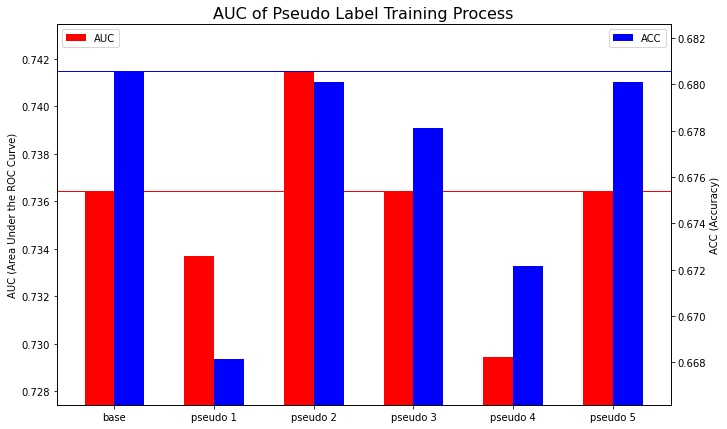

In [ ]:
# 결과 시각화

pseudo.visualize()

### output.csv 생성
> 현재 실험에서는 pseudo1 모델이 가장 valid AUC가 높기 때문에 pseudo1의 test set 예측 결과를 제출

In [ ]:
pseudo1_pred = pseudo.preds[1]

In [ ]:
write_path = os.path.join(args.output_dir, "output.csv")
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)    

with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(pseudo1_pred):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/output.csv
